In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy import exp as exp
import scipy.io as sio

1. Изменила соотношение каналов натрия
2. Убрала воду
3.  подвести под время +
4. сделать анализ устойчивости +
5. Сделать новые графики, выбрать временной масштаб+


# Creation of folder for plots saving in png files

In [68]:
import os
folder_name = "figs"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Na,K-ATPase surface approximation

In [69]:
#Array export and creating

CK = np.arange(0, 0.110001, 0.005) #23
CNa = np.arange(0, 0.50001, 0.025) #21
psi = np.arange(-80, 261, 20) #18
flux_psi = sio.loadmat('flux_psi.mat')['flux_psi']
kflux_psi = sio.loadmat('kflux_psi.mat')['kflux_psi']
naflux_psi = sio.loadmat('naflux_psi.mat')['naflux_psi']

In [70]:
def interpolate_flux(K, Na, Psi, CK=CK, CNa=CNa, psi=psi, flux_psi=naflux_psi):
    def find_nearest_indices(value, array):
        idx = np.searchsorted(array, value)
        idx = np.clip(idx, 1, len(array) - 1)
        return idx - 1, idx

    def interpolate_1d(value, array, idx1, idx2):
        x1, x2 = array[idx1], array[idx2]
        return (value - x1) / (x2 - x1)

    k_idx1, k_idx2 = find_nearest_indices(K, CK)
    na_idx1, na_idx2 = find_nearest_indices(Na, CNa)
    psi_idx1, psi_idx2 = find_nearest_indices(Psi, psi)

    k_ratio = interpolate_1d(K, CK, k_idx1, k_idx2)
    na_ratio = interpolate_1d(Na, CNa, na_idx1, na_idx2)
    psi_ratio = interpolate_1d(Psi, psi, psi_idx1, psi_idx2)

    c00 = flux_psi[k_idx1, na_idx1, psi_idx1] * (1 - k_ratio) + flux_psi[k_idx2, na_idx1, psi_idx1] * k_ratio
    c01 = flux_psi[k_idx1, na_idx1, psi_idx2] * (1 - k_ratio) + flux_psi[k_idx2, na_idx1, psi_idx2] * k_ratio
    c10 = flux_psi[k_idx1, na_idx2, psi_idx1] * (1 - k_ratio) + flux_psi[k_idx2, na_idx2, psi_idx1] * k_ratio
    c11 = flux_psi[k_idx1, na_idx2, psi_idx2] * (1 - k_ratio) + flux_psi[k_idx2, na_idx2, psi_idx2] * k_ratio

    c0 = c00 * (1 - na_ratio) + c10 * na_ratio
    c1 = c01 * (1 - na_ratio) + c11 * na_ratio

    return c0 * (1 - psi_ratio) + c1 * psi_ratio

In [71]:
x = np.outer(np.linspace(0.01, 0.100, 300), np.ones(300))
y = np.outer(np.linspace(-100, 200, 300), np.ones(300)).T
z = np.vectorize(interpolate_flux)(x, 0.06 , y)
 


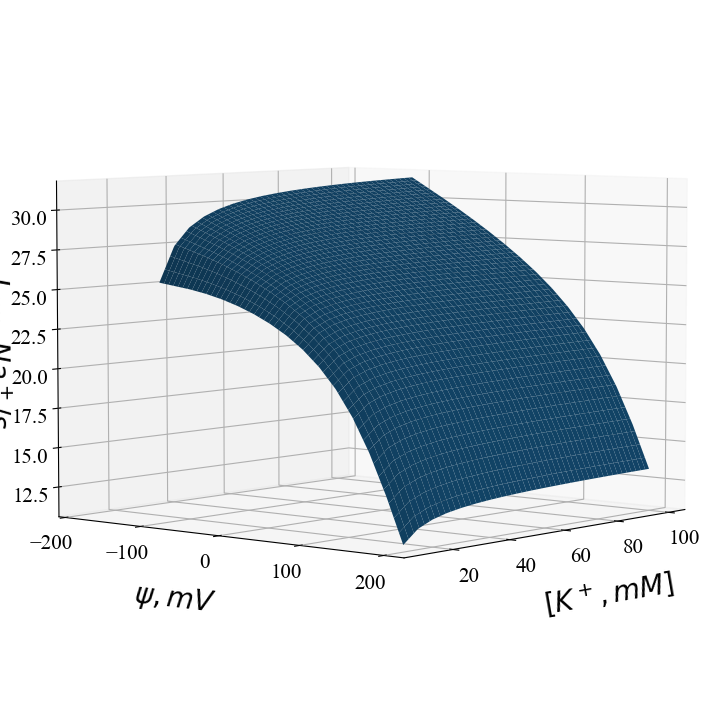

In [72]:
# Creating figure
fig = plt.figure(figsize = (14, 9), dpi = 100)
ax = plt.axes(projection ='3d')
ax.invert_xaxis()
# Creating plot
ax.plot_surface(x*1000, y, z)
ax.view_init(5, 40)
plt.xlabel(r'$[K^+, mM]$', fontsize = 20, labelpad=20)

plt.ylabel(r'$\psi, mV$', fontsize = 20, labelpad=20)
plt.xticks(fontsize = 15)
y_ticks = np.arange(-200, 201, 100)
plt.yticks(y_ticks, fontsize=15)
font = {'size': 15}
ax.tick_params('z', labelsize=font['size'])
#make zlabel another font 'Times new roman'ArithmeticError
z_label = ax.set_zlabel(r'$J_{NKA}, Na^+/s$', fontsize=20, rotation=120)


plt.savefig('figs/NKA_surface.png', dpi = 300)


# show plot
plt.show()

# vATPase function

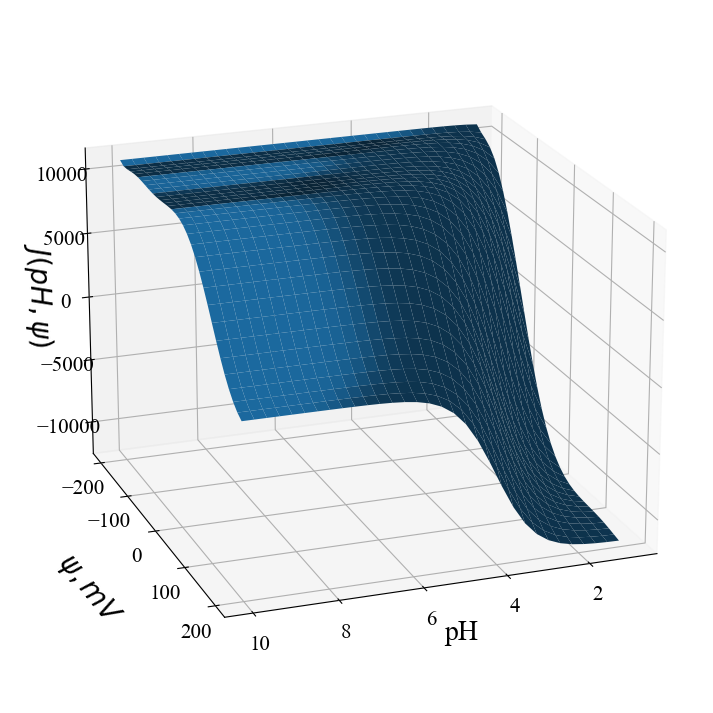

In [73]:
# @jit
def J_v(pH_L, psi):
    
    psi_start, psi_end = -300, 300
    pH_start, pH_end = 0, 9
    
    if (pH_L < pH_start):
        pH_L = pH_start
    elif (pH_L > pH_end):
        pH_L = pH_end
    
    if (psi < psi_start):
        psi = psi_start
    elif (psi > psi_end):
        psi = psi_end
    
    p_a = 3.3654e-24*psi**10+-1.72718633e-21*psi**9+-1.88006118e-19*psi**8+1.84428806e-16*psi**7+1.14875767e-15*psi**6+-7.86180209e-12*psi**5+8.73621142e-11*psi**4+1.38612359e-07*psi**3+4.02706504e-06*psi**2+-0.000921991562*psi**1+0.892742811*psi**0
    p_b = -0.01183303*psi**1+-1.74410965*psi**0
    p_c = 1.97927106e-17*psi**8+-8.11163955e-15*psi**7+-1.41331765e-12*psi**6+7.37414295e-10*psi**5+2.69242151e-08*psi**4+-1.47727446e-05*psi**3+-0.0018809272*psi**2+0.0294192901*psi**1+122.27226*psi**0
    p_d = 3.32575786e-13*psi**6+-3.43339599e-11*psi**5+-5.76545216e-08*psi**4+7.89631331e-06*psi**3+0.00138326473*psi**2+0.11950506*psi**1+1.50734239*psi**0
    
    
    J = np.tanh(p_a*pH_L + p_b)*p_c-p_d
    return J*550/6

x = np.outer(np.linspace(1, 10, 32), np.ones(32))
y = np.outer(np.linspace(-200, 200, 32), np.ones(32)).T
z = np.vectorize(J_v)(x, y)



 
# Creating figure
fig = plt.figure(figsize = (14, 9))
plt.rc('font', family='Times New Roman')
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(x, y, z)
ax.view_init(20, 70)
plt.xlabel(r'pH', fontsize = 20)

plt.ylabel(r'$\psi, mV$', fontsize = 20, labelpad=20)
plt.xticks(fontsize = 15)
y_ticks = np.arange(-200, 201, 100)
plt.yticks(y_ticks, fontsize=15)
font = {'size': 15}
ax.tick_params('z', labelsize=font['size'])
#make zlabel another font 'Times new roman'ArithmeticError
z_label = ax.set_zlabel(r'$J(pH, \psi)$', fontsize=20, rotation=60)
plt.savefig('figs/Approx_vATPase.png')


# show plot
plt.show()

# Constants and initial values

In [74]:
# Physical constants
F = 96485      #[C] Na*e
NA = 6.02e+23   # Avogadro constant [Particles/mol]
RTF = 26.72        #RT/F [mV]} 

# Lysosome sizes
init_R = 0.34            #organelle radius [microns]
init_V = (4/3*3.1416*init_R**3*1e-12)/1000 #{surface area [cm**2]}
init_S = 4*3.1416*init_R**2*1e-8 #{lysosome volume  [liters]}

# cytosolic initial concentrations and pH
Ca_C = 1e-07      #[M]
Cl_C = 0.05      #[M]
Na_C = 0.015      #[M]
K_C = 0.145      #[M]
pH_C = 7.2     



# Selective ion transporters settings
# Stoichiometries of ion transporters
CAX_Ca = 1       # Calcium stoichiometry of CAX
CAX_H = 3        # Proton stoichiometry of CAX 
CLC_Cl = 2       # Chloride stoichiometry of ClC-7
CLC_H = 1        # Proton stoichiometry of ClC-7

# Activities of ion transporters
N_CAX = 16      #Number of CAX []
N_CLC = 50      #Number of ClC-7 []
N_TPC = 38 #by patch 
N_TMEM = 1



init_Aeff = 0.3 #Initial effective activity of ClC-7
q = 2.2         # Coefficient for ClC-7
r = 0.1         #Deactivation to activation ratio for ClC-7
tau_act = 1     #Activation time for ClC-7 [s]
tau_deact = 0.25     #Activation time for ClC-7  for ClC-7 [s]
N_VATP = 6     #Number of vATPases []
N_NKA = 13000    #"Activity" of NKA []
p = 3.88e-12     #TRPML1 coefficient []

# Lysosome membrane permeabilities
P_Ca = 1.49e-7      #[ion*cm/s]
P_Cl = 1.2e-5       #[ion*cm/s]
P_H = 6e-05      #[ion*cm/s]
P_K = 7.1e-7 *1.6     #[ion*cm/s]
P_Na = 9.6e-7*686/1000      #[ion*cm/s]
Pw = 0.054e-2   #water permeability

# lysosome physical properties
beta_pH = 0.04      #[M/pH] Proton buffering capacity
cap = 1.45267584e-14      #[Farad] 
cap_0 = 1e-06      #[F/cm^2] membrane Bilayer capacitance 

# lysosome initial concentrations, potential and pH
init_Ca_F = 0.0005      #[M]
init_Ca_T = 0.005      #[M]
init_Cl = 0.100  #[M]
init_pH = 4.74
init_H = 0.05     #[M]
init_K = 0.060   #[M]
init_Na = 0.020   #[M]

psi_in = 0       #potential [mV]
psi_out = -50    #potential [mV]
# B is the concentration of Donnan particles, 
B = init_K+init_Na+init_H-init_Cl  + init_Ca_T*2 - cap/F/init_V*(psi_in - psi_out) 


      


# Osmolarities
Oc = 0.291
oh =  0.73
ok =  0.73
ona = 0.73
ocl = 0.73
Q = init_V*(Oc - (oh*10**(-init_pH) + ok*init_K + ona*init_Na + ocl*init_Cl))

# Derivatives

In [75]:
# @jit
def derivatives(X, t, stress = 'No', k_times = 4, ind_vATPase = 1):
    '''
    compute derivatives of X wrt time
    '''
    Aeff, NH, pH, NK, NNa, NCl, NCa_T, NCa_F, R = X

    N_VATP = 6
    N_CAX = 16
    p = 3.88e-12

    P_Ca = 1.49e-7      #[ion*cm/s]
    P_Cl = 1.2e-5       #[ion*cm/s]
    P_H = 6e-05      #[ion*cm/s]
    P_K = 7.1e-7 *1.6     #[ion*cm/s]
    P_Na = 9.6e-7*686/1000      #[ion*cm/s]
    Pw = 0.054e-2   #water permeability

    pure_basefication = 0

    if stress == 'Permeabilization10':
        if ((t>800) and (t<1500)):
            n_per = 10
            P_Ca = 1.49e-7*686/1000 *n_per        #[ion*cm/s]
            P_Cl = 1.2e-5*n_per       #[ion*cm/s]
            P_H = 6e-05*n_per        #[ion*cm/s]
            P_K = 7.1e-7*1.6 *n_per        #[ion*cm/s]
            P_Na = 9.6e-7*n_per   
            Pw = 0.054e-2*n_per  

        
        else:
            P_Ca = 1.49e-7        #[ion*cm/s]
            P_Cl = 1.2e-5       #[ion*cm/s]
            P_H = 6e-05      #[ion*cm/s]
            P_K = 7.1e-7      #[ion*cm/s]
            P_Na = 9.6e-7 
            Pw = 0.054e-2

    if stress == 'Permeabilization100':
        if ((t>800) and (t<1500)):
            n_per = 100
            P_Ca = 1.49e-7*n_per        #[ion*cm/s]
            P_Cl = 1.2e-5*n_per       #[ion*cm/s]
            P_H = 6e-05*n_per        #[ion*cm/s]
            P_K = 7.1e-7*n_per        #[ion*cm/s]
            P_Na = 9.6e-7*n_per   
            Pw = 0.054e-2*n_per  

        
        else:
            P_Ca = 1.49e-7        #[ion*cm/s]
            P_Cl = 1.2e-5       #[ion*cm/s]
            P_H = 6e-05      #[ion*cm/s]
            P_K = 7.1e-7      #[ion*cm/s]
            P_Na = 9.6e-7 
            Pw = 0.054e-2


        
        
    if stress == 'Ca_v':
        if (t>2000):
            N_VATP = 1
        else:
            N_VATP = 6

    if stress == 'Ca_al':
        pure_basefication = int((t>=2000))*4.62e4
     
    
    V = (4/3*3.1416*abs(R)**3*1e-12)/1000
    S = 4*3.1416*abs(R)**2*1e-8


    #Luminal Concentrations
    H = NH/V/NA
    K = NK/V/NA
    Na = NNa/V/NA
    Cl = NCl/V/NA
    Ca_F = NCa_F/V/NA
    Ca_T = NCa_T/V/NA
    r = Ca_F/Ca_T

    
    #membrane potential
#     psi = (F/cap)*init_V*(H + K + Na - Cl + 2*Ca_T - B)
    psi = (F/cap)*(V*(H + K + Na - Cl + 2*Ca_T) - B*init_V)


#      Modified Cytoplasmic Surface Concentrations
    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    K_C0    = K_C*exp(-psi_out/RTF)
    Na_C0   = Na_C*exp(-psi_out/RTF) 
    Cl_C0   = Cl_C*exp(psi_out/RTF) 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    
#     Modified Luminal Surface Concentrations
    pH_L0   = (pH+psi_in/(RTF*2.3))
    K_L0    = K*exp(-psi_in/RTF)
    Na_L0   = Na*exp(-psi_in/RTF) 
    Cl_L0   = Cl*exp(psi_in/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    delta_pH    = pH_C0-pH_L0;  

#     Treatment of singular terms for passive ion flux
    if (abs(psi) > 300):
        psi = np.sign(psi)*300
    if (abs(psi) > 0.01):
        gg      =  psi / (1 - exp (- psi / RTF)) / RTF
        gg_Ca   = 2*psi/(1-exp(-2*psi/RTF))/RTF

    else: 
        gg      =  1 / 1 - (psi / RTF)/2 + (psi / RTF)**2/6 - (psi / RTF)**3 / 24 + (psi / RTF) ** 4 / 120
        gg_Ca   = 1/(1 - (psi/RTF) + (2/3)*(psi/RTF)**2 - (1/3)*(psi/RTF)**3 +(2/15)*(psi/RTF)**4)


        

    # vAPTase
    J_VATPASE  = N_VATP * J_v(pH, psi) * ind_vATPase


        # ClC-7 Antiporter {H out, Cl in}
    CLC_mu      = (CLC_H + CLC_Cl)*psi + RTF*(CLC_H*2.3*delta_pH + CLC_Cl*np.log(Cl_C0/Cl_L0))
    
    #     Switching function   
    x = 0.5 + 0.5*np.tanh((CLC_mu + 250)/75); 
    # Activity
    A = 0.3*x + 1.5E-5*(1-x)*CLC_mu**2;
    
    if (A < Aeff):
        tau = tau_deact
    else:
        tau = tau_act
        
    J_CLC    = N_CLC*Aeff*CLC_mu 
    
    
#      CAX Antiporter {H out, Ca in} [mV, ion/s]
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = N_CAX*CAX_mu
    
    
    
    
#      Passive flux [ion/s]
    J_H = P_H*S*(10**(-pH_C0)*exp(-psi/RTF)-10**(-pH_L0))*gg*NA/1000
    J_K = P_K*S*(K_C0*exp(-psi/RTF)-K_L0)*gg*NA/1000 #this is TMEM
    J_Na = P_Na*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000
    J_Cl_unc = P_Cl*S*(Cl_C0-Cl_L0*exp(-psi/RTF))*gg*NA/1000
    J_Ca = P_Ca*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000
    


    
    #water flux
    J_w = Pw*S*(oh*10**(-pH) + ok*K + ona*Na + ocl*Cl + Q/V - Oc)
    
#     TRPML1 channel
    y = 0.5 - 0.5*np.tanh(psi + 40)
    P_trpml1 = p*(y*abs(psi) + (1-y)*(abs (psi + 40)**3)/(pH_L0**q))
    J_Ca_trpml1 = P_trpml1*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000

    J_vNa = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = naflux_psi)*0
    J_vK = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = kflux_psi)*0


    #   TPC {Na out}
    
    xh = 6.7e3*exp(-0.9*pH) - 15
    k = 11.3*pH**2 - 116.5*pH + 325.3
    P_TPC = 1/(1+exp((xh-psi)/k))
    J_TPC = N_TPC*P_TPC*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000


    if stress == 'Fast_vastpase_stress':
        if (t>500 and t<850):
            J_VATPASE = 0

    if stress == 'Fast_swelling':
        if (t>500 and t<850):
            J_w += 1e-13

    if (NCa_T + J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)<=0:
        J_Ca = 0
        J_CAX = 0
        J_Ca_trpml1 = 0
        print('Ca concentration is too close to negative')

    # if (NCa_F + (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)*r)<=0:
    #     J_Ca = 0
    #     J_CAX = 0
    #     J_Ca_trpml1 = 0
    #     print('!!')


    
    dxdt = [(1/tau)*(A - Aeff)/k_times,
        (J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication)/k_times, 
           (-(J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication)/V/NA)/beta_pH/k_times,
           (J_K + N_NKA*J_vK)/k_times,
           (J_Na + N_NKA*J_vNa + J_TPC)/k_times,
           (J_Cl_unc + (CLC_Cl*J_CLC))/k_times,
           (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)/k_times,
           (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)*r/k_times, 
           J_w/(1000*55)/(4*np.pi*(R/1e5)**2)*1e5*0]

    return dxdt

In [76]:
init_NH = init_H*init_V*NA;      #[ions]
init_NK = init_K*init_V*NA;       
init_NNa = init_Na*init_V*NA;    
init_NCl = init_Cl*init_V*NA;     
init_NCa_T = init_Ca_T*init_V*NA; 
init_NCa_F = init_Ca_F*init_V*NA; 

X0 = [init_Aeff, init_NH, init_pH, init_NK, init_NNa, init_NCl, init_NCa_T, init_NCa_F, init_R]

# Plots

In [77]:
def set_plot_font_params():
    """
    Set the font parameters for all plots in the Matplotlib instance.
    """
    # Set the font family and style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Times new roman']
    plt.rcParams['font.style'] = 'normal'

    # Set the font sizes
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 20
set_plot_font_params()

In [78]:
def V_arr_def(solution):
    V_arr = (4/3*3.1416*solution[:, 8]**3*1e-12)/1000
    return V_arr

def Psi_arr_def(solution, V_arr):
    psi_arr = (F/cap)*(V_arr*(solution[:, 1]/V_arr/NA + solution[:, 3]/V_arr/NA + solution[:, 4]/V_arr/NA - solution[:, 5]/V_arr/NA + 2*solution[:, 6]/V_arr/NA) - B*init_V)
    return psi_arr
    
def J_w_arr_def(solution, V_arr):
    J_w_arr = Pw*4*3.1416*abs(solution[:, 8])**2*1e-8*(oh*10**(-solution[:, 2]) + ok*solution[:, 3]/V_arr/NA + ona*solution[:, 4]/V_arr/NA + ocl*solution[:, 5]/V_arr/NA + Q/V_arr - Oc)
    return J_w_arr*1000*NA





In [79]:
def plot_solution_concentrations(t, solution, solution_stat, V_arr, V_arr_stat, 
                                 x_text = 0.36, legend_loc=[0.55, 0.6], save = False, save_solder = 'figs', save_name = '', show_Ca = False,
                                 show_H = False):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    ca_conc = solution[:, 7] / V_arr / NA*1000
    cl_conc = solution[:, 5] / V_arr / NA*1000
    k_conc = solution[:, 3] / V_arr / NA*1000
    na_conc = solution[:, 4] / V_arr / NA*1000
    h_conc = solution[:, 1] / V_arr / NA*1000


    ca_stat = solution_stat[:, 7][-1] / V_arr_stat[-1] / NA*1000
    cl_stat = solution_stat[:, 5][-1] / V_arr_stat[-1] / NA*1000
    k_stat = solution_stat[:, 3][-1] / V_arr_stat[-1] / NA*1000
    na_stat = solution_stat[:, 4][-1] / V_arr_stat[-1] / NA*1000
    h_stat = solution_stat[:, 1][-1] / V_arr_stat[-1] / NA*1000

    t = t/3600
    # Plot the concentrations
    ax.plot(t, cl_conc, 'b', label='Cl(t)')
    ax.plot(t, k_conc, 'r', label='K(t)')
    ax.plot(t, na_conc, 'g', label='Na(t)')

    ax.set_ylabel('Ions concentrations, mM', fontsize=30, labelpad=10)
    ax.set_xlabel('Time, h', fontsize=30)
    ax.tick_params(axis='both', labelsize=20)
#     ax.set_adjustable('box')
    # plt.xlim(0, 3.5)
    # Extend the horizontal lines beyond the plot area
    ax.axhline(cl_stat, 0, 1, color = 'b', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax.axhline(k_stat, 0, 1, color = 'r', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax.axhline(na_stat, 0, 1, color = 'g', clip_on=False, linestyle='dashed', alpha = 0.4)



    ax.text(x=x_text, y=cl_stat*1.02, s=round(cl_stat, 1), fontsize=18, color='b')
    ax.text(x=x_text, y=k_stat*1.015, s=round(k_stat, 1), fontsize=18, color='r')
    ax.text(x=x_text, y=na_stat*1.01, s=round(na_stat, 1), fontsize=18, color='g')

    if show_Ca:
        ax.plot(t, ca_conc, 'purple', label='Ca(t)')
        ax.axhline(ca_stat, 0, 1, color = 'purple', clip_on=False, linestyle='dashed', alpha = 0.4)
        ax.text(x=x_text, y=ca_stat*1.01, s=round(ca_stat, 1), fontsize=18, color='purple')
    if show_H:
        ax.plot(t, h_conc, 'black', label='H(t)')
        ax.axhline(h_stat, 0, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
        ax.text(x=x_text, y=h_stat*1.01, s=round(h_stat, 1), fontsize=18, color='black')
    ax.legend(loc=legend_loc, fontsize=20, frameon=False)

    plt.tight_layout()

    if save:
        plt.savefig(f'{save_solder}/{save_name}_conc.png', dpi = 300)
    plt.show()



In [80]:
def plot_solution_concentrations_stress(t, solution, solution_stat, V_arr, V_arr_stat, 
                                 x_text = 0.36, legend_loc=[0.55, 0.6], save = False, save_solder = 'figs', save_name = '', show_Ca = False,
                                 show_H = False, stress_time = [80000, 150000]):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    ca_conc = solution[:, 7] / V_arr / NA*1000
    cl_conc = solution[:, 5] / V_arr / NA*1000
    k_conc = solution[:, 3] / V_arr / NA*1000
    na_conc = solution[:, 4] / V_arr / NA*1000
    h_conc = solution[:, 1] / V_arr / NA*1000


    ca_stat = solution_stat[:, 7][-1] / V_arr_stat[-1] / NA*1000
    cl_stat = solution_stat[:, 5][-1] / V_arr_stat[-1] / NA*1000
    k_stat = solution_stat[:, 3][-1] / V_arr_stat[-1] / NA*1000
    na_stat = solution_stat[:, 4][-1] / V_arr_stat[-1] / NA*1000
    h_stat = solution_stat[:, 1][-1] / V_arr_stat[-1] / NA*1000

    t = t/3600
    # Plot the concentrations
    ax.plot(t, cl_conc, 'b', label='Cl(t)')
    ax.plot(t, k_conc, 'r', label='K(t)')
    ax.plot(t, na_conc, 'g', label='Na(t)')

    ax.set_ylabel('Ions concentrations, mM', fontsize=30, labelpad=10)
    ax.set_xlabel('Time, h', fontsize=30)
    ax.tick_params(axis='both', labelsize=20)
#     ax.set_adjustable('box')
    # plt.xlim(0, 3.5)
    # Extend the horizontal lines beyond the plot area
    ax.axhline(cl_stat, 0, 1, color = 'b', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax.axhline(k_stat, 0, 1, color = 'r', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax.axhline(na_stat, 0, 1, color = 'g', clip_on=False, linestyle='dashed', alpha = 0.4)



    ax.text(x=x_text, y=cl_stat*1.02, s=round(cl_stat, 1), fontsize=18, color='b')
    ax.text(x=x_text, y=k_stat*1.015, s=round(k_stat, 1), fontsize=18, color='r')
    ax.text(x=x_text, y=na_stat*1.01, s=round(na_stat, 1), fontsize=18, color='g')

    cl_stress = cl_conc[stress_time[1]-1000]
    k_stress = k_conc[stress_time[1]-1000]
    na_stress = na_conc[stress_time[1]-1000]
    h_stress = h_conc[stress_time[1]-1000]
    ca_stress = ca_conc[stress_time[1]-1000]



    ax.text(x=(stress_time[0]+stress_time[1])/2.2/360000, y=cl_stress+2, s=round(cl_stress, 1), fontsize=18, color='b')
    ax.text(x=(stress_time[0]+stress_time[1])/2.2/360000, y=k_stress+3, s=round(k_stress, 1), fontsize=18, color='r')
    ax.text(x=(stress_time[0]+stress_time[1])/2.2/360000, y=na_stress+3, s=round(na_stress, 1), fontsize=18, color='g')
    print(ca_stress)

    if show_Ca:
        ax.plot(t, ca_conc, 'purple', label='Ca(t)')
        ax.axhline(ca_stat, 0, 1, color = 'purple', clip_on=False, linestyle='dashed', alpha = 0.4)
        ax.text(x=x_text, y=ca_stat*1.01, s=round(ca_stat, 1), fontsize=18, color='purple')
        ax.text(x=(stress_time[0]+stress_time[1])/2/360000, y=ca_stress+3, s=round(ca_stress, 4), fontsize=18, color='purple')
    if show_H:
        ax.plot(t, h_conc, 'black', label='H(t)')
        ax.axhline(h_stat, 0, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
        ax.text(x=x_text, y=h_stat*1.01, s=round(h_stat, 1), fontsize=18, color='black')
        ax.text(x=(stress_time[0]+stress_time[1])/2/360000, y=h_stress*1.01, s=round(h_stress, 1), fontsize=18, color='black')
    ax.legend(loc=legend_loc, fontsize=20, frameon=False)
    
    ax.set_ylim(-5, 1.1*max(cl_stress, k_stress, na_stress))
    plt.tight_layout()
    

    if save:
        plt.savefig(f'{save_solder}/{save_name}_conc_stress.png', dpi = 300)
    plt.show()



In [81]:
def plot_solution_pH_psi(t, solution, solution_stat, psi_arr, psi_stat, 
                         set_pHlim = False, pHlim = [0, 0], set_psi_lim = False, psi_lim = [0, 0] ,psi_text = 0.2, pH_text = 0.8, save = False, save_solder = 'figs', save_name = ''):
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)

    t = t/3600

    # Plot R(t)
    ax1.plot(t, solution[:, 2], 'black', label='pH$(t)$')
    ax1.set_ylabel(r'pH', fontsize=30, color='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.axhline(solution_stat[:, 2][-1], 0, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax1.text(0.95, pH_text, 'Final pH: {:.3f}'.format(solution_stat[:, 2][-1]), transform=ax1.transAxes, ha='right', va='top', fontsize=20, color='black')

    # Create a second y-axis for J_w_arr
    ax2 = ax1.twinx()

    # Plot J_w_arr

    ax2.plot(t, psi_arr, 'r', label=r'$\Psi$(t)', alpha=1)  # Set transparency with alpha
    ax2.set_ylabel(r'$\Delta\Psi$, mV', fontsize=30, color='r')
    ax2.tick_params(axis='y', colors='black', labelcolor='red')
    ax2.axhline(psi_stat, 0, 1, color = 'r', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax2.text(0.95, psi_text, 'Final $\Psi$: {:.2f} mV'.format(psi_stat), transform=ax2.transAxes, ha='right', va='top', fontsize=20, color='r')

    # ax1.set_xlim(0, 0.35)
    
    if set_pHlim:
        ax1.set_ylim(pHlim[0], pHlim[1])
    if set_psi_lim:
        ax2.set_ylim(psi_lim[0], psi_lim[1])

    
    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=30)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black

    plt.tight_layout()

    if save:
        plt.savefig(f'{save_solder}/{save_name}_PsiPh.png', dpi = 300)
    plt.show()



In [82]:
def plot_solution_R(t, solution, solution_stat, V_arr, V_arr_stat, J_w_arr, J_w_arr_stat, R_text = 0.85, R_show = True, 
                    swelling = 0, set_Rlim = False, Rlim = [0, 0], save = False, save_solder = 'figs', save_name = ''):
    
    J_w_arr_stat = J_w_arr_stat[-1]
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)
    t = t/3600

    # Plot R(t)
    ax1.plot(t, solution[:, 8], 'black', label='R(t)')
    ax1.set_ylabel(r'R, $\mu$m', fontsize=30, color='black')
    ax1.tick_params(axis='y', colors='black')

    ax1.axhline(solution_stat[:, 8][-1], 0.2, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    
    if R_show:
        ax1.text(0.95, R_text, 'Final radius: {:.3f} $\mu$m'.format(solution_stat[:, 8][-1]), transform=ax1.transAxes, ha='right', va='top', fontsize=20, color='black')


    # Create a second y-axis for J_w_arr
    ax2 = ax1.twinx()

    # Plot J_w_arr
    if swelling:
        J_w_arr = J_w_arr + (t*3600 <550)*(t*3600>500)*1e-13*1000*NA

    ax2.plot(t, J_w_arr, 'b', label='J_w_arr', alpha=0.6)  # Set transparency with alpha
    ax2.set_ylabel(r'Water flux, $H_2O$/s', fontsize=30, color='b')
    ax2.tick_params(axis='y', colors='white', labelcolor='b')
    ax2.axhline(0, 0.2, 1, linestyle = 'dashed', alpha = 0.4)
    

    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=30)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black

    if set_Rlim:
        ax1.set_ylim(Rlim[0], Rlim[1])

    plt.tight_layout()

    if save:
        plt.savefig(f'{save_solder}/{save_name}_RJw.png', dpi = 300)
    plt.show()







In [83]:
def plot_solution_ion_numbers(t, solution, solution_stat, V_arr, V_arr_stat, 
                                 x_text = 0.36, legend_loc=[0.55, 0.6], save = False, save_solder = 'figs', save_name = '', show_Ca = False,
                                 show_H = False, xlim=[0,0], ylim=[0,0]):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    ca_conc = solution[:, 7]
    cl_conc = solution[:, 5] 
    k_conc = solution[:, 3] 
    na_conc = solution[:, 4] 
    h_conc = solution[:, 1] 


    ca_stat = solution_stat[:, 7][-1] 
    cl_stat = solution_stat[:, 5][-1] 
    k_stat = solution_stat[:, 3][-1] 
    na_stat = solution_stat[:, 4][-1] 
    h_stat = solution_stat[:, 1][-1] 

    t = t/3600
    # Plot the concentrations
    ax.plot(t, cl_conc, 'b', label='Cl(t)')
    ax.plot(t, k_conc, 'r', label='K(t)')
    ax.plot(t, na_conc, 'g', label='Na(t)')

    ax.set_ylabel('Ions concentrations, mM', fontsize=30, labelpad=10)
    ax.set_xlabel('Time, h', fontsize=30)
    ax.tick_params(axis='both', labelsize=20)
#     ax.set_adjustable('box')
    # plt.xlim(0, 3.5)
    # Extend the horizontal lines beyond the plot area
    ax.axhline(cl_stat, 0, 1, color = 'b', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax.axhline(k_stat, 0, 1, color = 'r', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax.axhline(na_stat, 0, 1, color = 'g', clip_on=False, linestyle='dashed', alpha = 0.4)



    # ax.text(x=x_text, y=cl_stat*1.02, s=round(cl_stat, 1), fontsize=18, color='b')
    # ax.text(x=x_text, y=k_stat*1.015, s=round(k_stat, 1), fontsize=18, color='r')
    # ax.text(x=x_text, y=na_stat*1.01, s=round(na_stat, 1), fontsize=18, color='g')

    if show_Ca:
        ax.plot(t, ca_conc, 'purple', label='Ca(t)')
        ax.axhline(ca_stat, 0, 1, color = 'purple', clip_on=False, linestyle='dashed', alpha = 0.4)
        # ax.text(x=x_text, y=ca_stat*1.01, s=round(ca_stat, 1), fontsize=18, color='purple')
    if show_H:
        ax.plot(t, h_conc, 'black', label='H(t)')
        ax.axhline(h_stat, 0, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
        # ax.text(x=x_text, y=h_stat*1.01, s=round(h_stat, 1), fontsize=18, color='black')
    ax.legend(loc=legend_loc, fontsize=20, frameon=False)

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])

    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])

    plt.tight_layout()

    if save:
        plt.savefig(f'{save_solder}/{save_name}_ionN.png', dpi = 300)
    plt.show()



In [84]:
def plot_vATPase_work(t, solution, solution_stat, save_name, psi_arr, psi_arr_stat, text_loc = [0.1, 8000], text=0):
    t = t/3600
    plt.figure(figsize=(6,6), dpi=100)
    v_arr = np.vectorize(J_v)(solution[:, 2], psi_arr)
    v_arr_stat = J_v(solution_stat[:, 2][-1], psi_arr_stat[-1])
    plt.plot(t, v_arr, 'g', label='J_v$(t)$')
    plt.ylabel(r'vATPase activity, $H^{+}$/s', fontsize=30)
    plt.xlabel('Time, h', fontsize=30)
    plt.xticks(fontsize=20)
    plt.hlines(v_arr_stat, t[0], t[-1], linestyle='--', color='g', label='J_v$(t_{stat})$')
    plt.yticks(fontsize=20)
    plt.tight_layout()
    if text:
        plt.text(text_loc[0], text_loc[1], ' Final vATPase \n activity = \n'  + str(round(v_arr_stat, 2)) + r' $H^+$/s', fontsize=20)
    plt.savefig('figs/' + save_name + '_JV.png', dpi=300)
    plt.show()



# Lysosome in norm

In [85]:
tspan = np.arange(0, 1200, 1e-2)
solution = odeint(derivatives, X0, tspan)

tspan_stat = np.arange(0, 40000, 1e-2)
solution_stat = odeint(derivatives, X0, tspan_stat)

In [86]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

V_arr_stat = V_arr_def(solution_stat)
psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

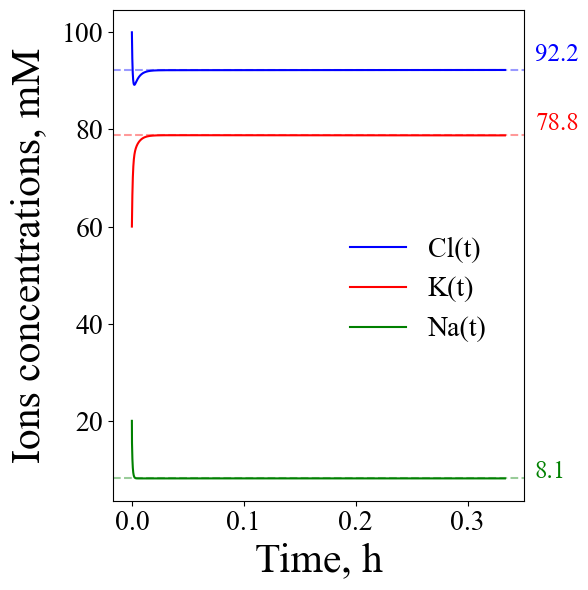

In [87]:
plot_solution_concentrations(tspan, solution, solution_stat=solution_stat, V_arr=V_arr, V_arr_stat=V_arr_stat,
                              legend_loc=[0.55, 0.3], save=False, save_name='normal')


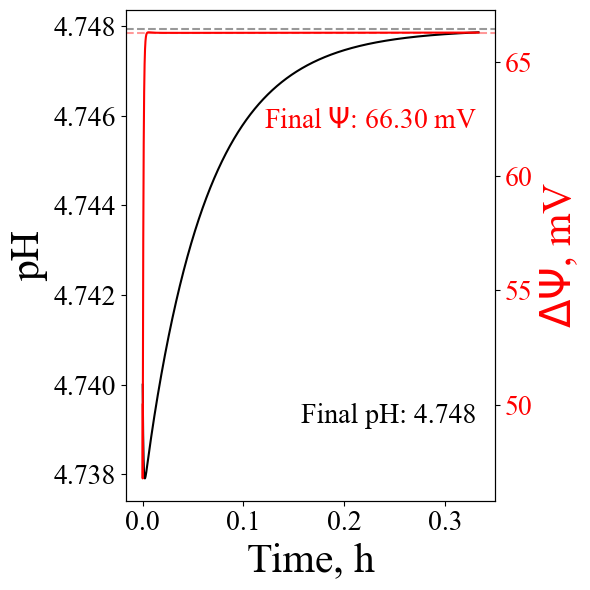

In [88]:
plot_solution_pH_psi(tspan, solution, solution_stat, psi_arr, psi_arr_stat[-1], psi_text=0.8, pH_text=0.2, save_name='normal', save = False)

# pH rate 


In [89]:
init_NH = init_H*init_V*NA;      #[ions]
init_NK = init_K*init_V*NA;       
init_NNa = init_Na*init_V*NA;    
init_NCl = init_Cl*init_V*NA;     
init_NCa_T = init_Ca_T*init_V*NA; 
init_NCa_F = init_Ca_F*init_V*NA; 

X0 = [init_Aeff, init_NH, 7.2, init_NK, init_NNa, init_NCl, init_NCa_T, init_NCa_F, init_R]

In [90]:
tspan = np.arange(0, 1000, 1e-2)
solution_ATP = odeint(derivatives, X0, tspan)

tspan_stat = np.arange(0, 1000, 1e-2)
solution_no_ATP = odeint(derivatives, X0, tspan, args=('No', 4, 0))

Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to negative
Ca concentration is too close to n

In [91]:
V_arr = V_arr_def(solution_ATP)
psi_arr = Psi_arr_def(solution_ATP, V_arr)
J_w_arr = J_w_arr_def(solution_ATP, V_arr)

V_no_ATP = V_arr_def(solution_no_ATP)
psi_arr_no_ATP = Psi_arr_def(solution_no_ATP, V_no_ATP)
# J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

In [92]:
def plot_solution_pH_pH(t, solution_1, solution_2, 
                         set_pHlim = False, pHlim = [0, 0], set_psi_lim = False, psi_lim = [0, 0] ,psi_text = 0.2, pH_text = 0.8, save = False, save_solder = 'figs', save_name = ''):
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)

    t = t/60

    # Plot R(t)
    ax1.plot(t, solution_1[:, 2], 'black', label='ATP')
    ax1.set_ylabel(r'pH', fontsize=30, color='black')
    ax1.tick_params(axis='y', colors='black')


    # Create a second y-axis for J_w_arr
    
    # Plot J_w_arr

    ax1.plot(t, solution_2[:, 2], 'r', label='no ATP')  # Set transparency with alpha
    

    # ax1.set_xlim(0, 0.35)
    
    if set_pHlim:
        ax1.set_ylim(pHlim[0], pHlim[1])
    plt.xlim(left=0)

    
    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=30)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black
    plt.legend()

    plt.tight_layout()
    

    if save:
        plt.savefig(f'{save_solder}/{save_name}_pH.png', dpi = 300)
    plt.show()



In [93]:
def plot_solution_der_pH(t, solution_1, solution_2, 
                         set_pHlim = False, pHlim = [0, 0], set_psi_lim = False, psi_lim = [0, 0] ,psi_text = 0.2, pH_text = 0.8, save = False, save_solder = 'figs', save_name = ''):
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)

    t = t/60
    pH_der_1 = -np.gradient(solution_1[:, 2], t)
    pH_der_2 = -np.gradient(solution_2[:, 2], t)

    ax1.plot(t, pH_der_1, 'black', label='ATP')
    ax1.set_ylabel(r'Acidification rate $\Delta$pH/min', fontsize=30, color='black')
    ax1.tick_params(axis='y', colors='black')
    

    # Create a second y-axis for J_w_arr
    
    # Plot J_w_arr

    ax1.plot(t, pH_der_2, 'r', label='no ATP')  # Set transparency with alpha
    

    # ax1.set_xlim(0, 0.35)
    
    if set_pHlim:
        ax1.set_ylim(pHlim[0], pHlim[1])
   
    plt.xlim(left = 0)

    
    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=30)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black
    plt.legend()

    plt.tight_layout()

    if save:
        plt.savefig(f'{save_solder}/{save_name}_pHder.png', dpi = 300)
    plt.show()



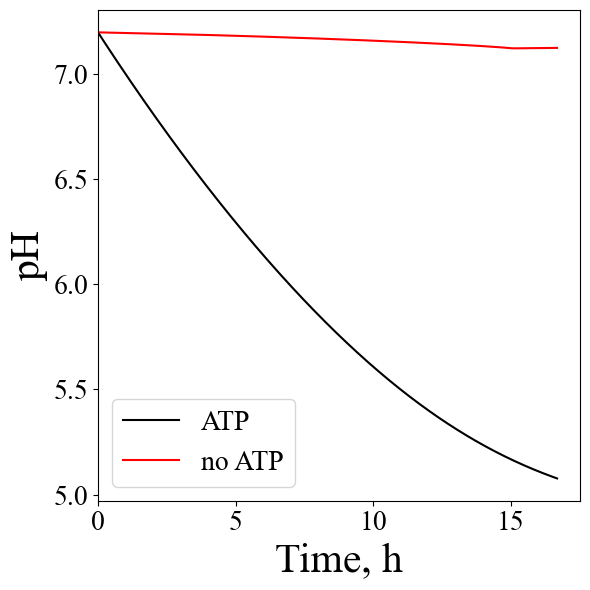

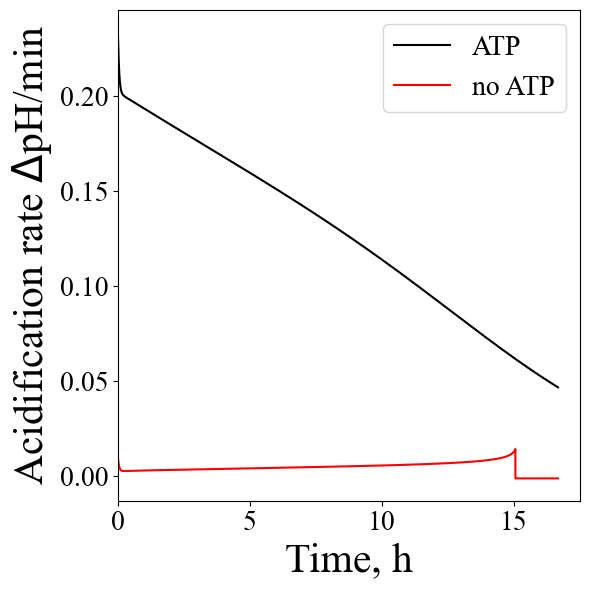

In [94]:
plot_solution_pH_pH(tspan, solution_ATP, solution_no_ATP, save=1, save_solder='figs', save_name='pH_rate')
plot_solution_der_pH(tspan, solution_ATP, solution_no_ATP, save=1, save_solder='figs', save_name='pH_rate')

# Short vATPase shutdown

In [101]:
X0 = [init_Aeff, init_NH, init_pH, init_NK, init_NNa, init_NCl, init_NCa_T, init_NCa_F, init_R]

In [102]:
tspan = np.arange(0, 2500, 1e-2)
solution = odeint(derivatives, X0, tspan, args=('Fast_vastpase_stress', 4))
tspan_stat = np.arange(0, 40000, 1e-2)
solution_stat = odeint(derivatives, X0, tspan_stat, args=('Fast_vastpase_stress', 4))

In [103]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

V_arr_stat = V_arr_def(solution_stat)
psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

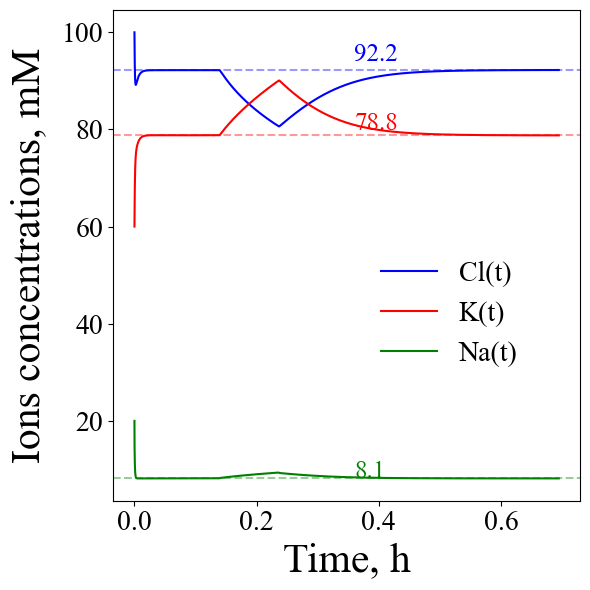

In [104]:
plot_solution_concentrations(tspan, solution, solution_stat=solution_stat, V_arr=V_arr, V_arr_stat=V_arr_stat,
                             legend_loc=[0.55, 0.25], save=True, save_name='Fast_vATPase')


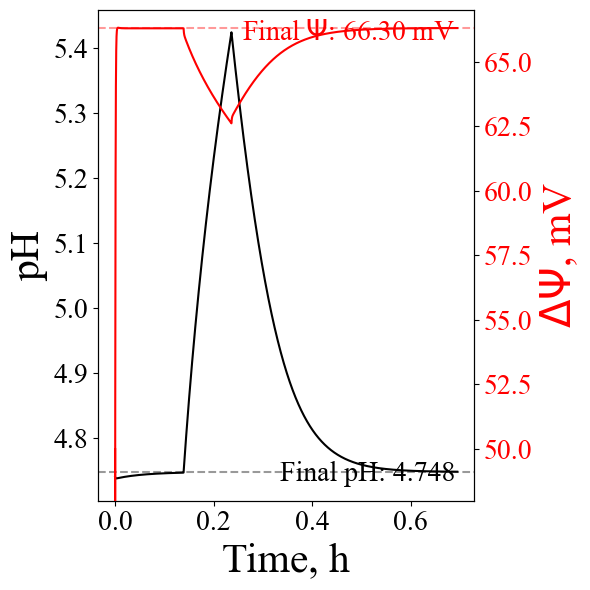

In [105]:
import numpy as np
plot_solution_pH_psi(tspan, solution, solution_stat, psi_arr, psi_arr_stat[-1], psi_text=0.98, pH_text=0.08,
                     set_psi_lim=True, psi_lim=[48, 67],
                     set_pHlim= 0, pHlim=[4.6, 5.5], save=True, save_name='Fast_vATPase')

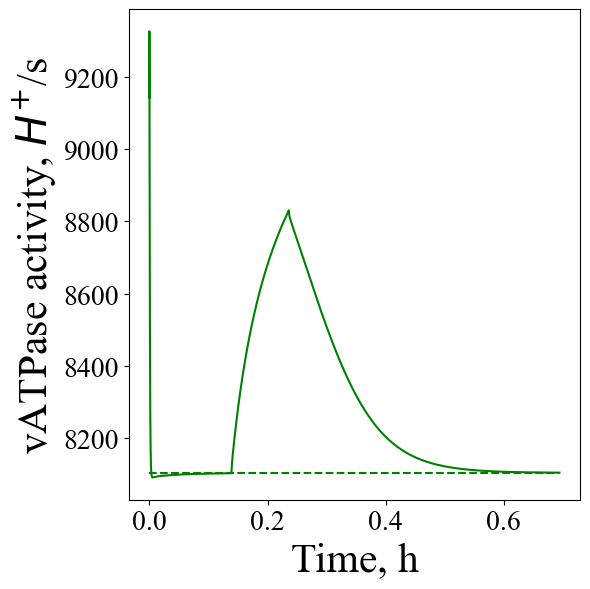

In [106]:
plot_vATPase_work(tspan, solution, solution_stat, 'Short_vATPase', psi_arr, psi_arr_stat, text_loc=[])

# Permeabilization

## Increase in ions permeabilities 10-fold

In [107]:
stress_name = 'Permeabilization10'

In [108]:
tspan = np.arange(0, 3000, 1e-2)
solution = odeint(derivatives, X0, tspan, args=('Permeabilization10',), hmax=1e-2)
tspan_stat = np.arange(0, 40000, 1e-2)
# solution_stat = odeint(derivatives, X0, tspan_stat, args=('Permeabilization',))

In [111]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

# V_arr_stat = V_arr_def(solution_stat)
# psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
# J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

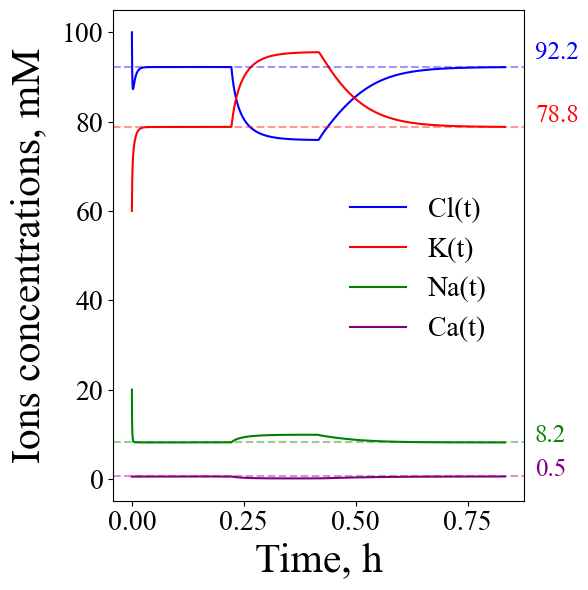

In [112]:
plot_solution_concentrations(tspan, solution, solution_stat=solution, V_arr=V_arr, V_arr_stat=V_arr,
                             x_text=0.9, legend_loc=[0.55, 0.3], save=True, save_name=stress_name, show_Ca=True)


0.09347697701671781


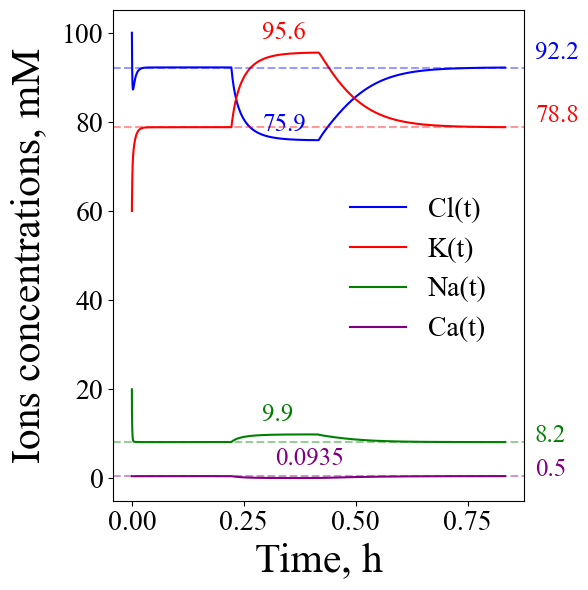

In [113]:
plot_solution_concentrations_stress(tspan, solution, solution_stat=solution, V_arr=V_arr, V_arr_stat=V_arr,
                             x_text=0.9, legend_loc=[0.55, 0.3], save=True, save_name=stress_name, show_Ca=True)


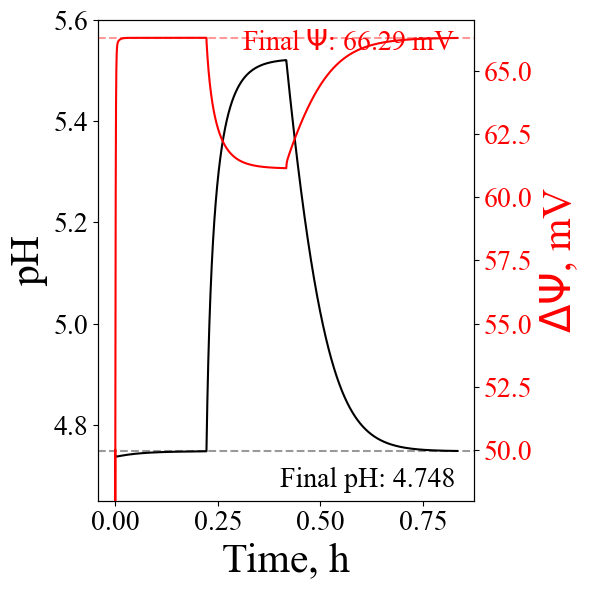

In [114]:
plot_solution_pH_psi(tspan, solution, solution, psi_arr, psi_arr[-1], 
                     psi_text=0.98, pH_text=0.07, set_pHlim=True, pHlim=[4.65, 5.6],
                     set_psi_lim=True, psi_lim=[48, 67],
                     save = True, save_name=stress_name)

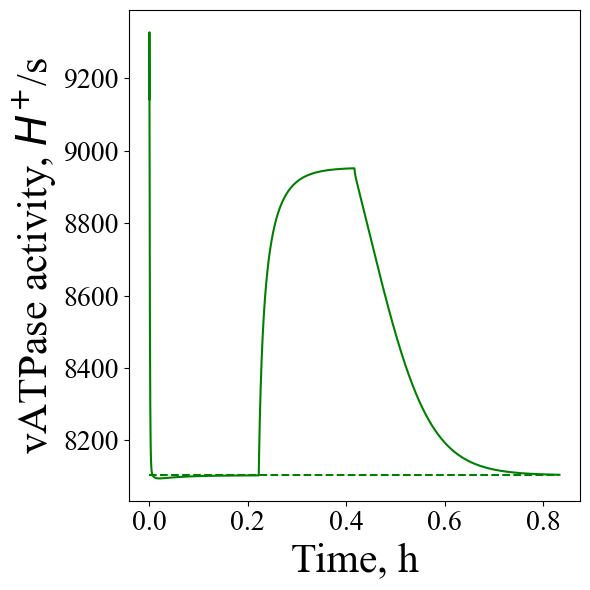

In [115]:


plot_vATPase_work(tspan, solution, solution, 'permeabilization10', psi_arr, psi_arr)

## Increase in ions permeabilities 100-fold

In [116]:
stress_name = 'Permeabilization100'

In [117]:
tspan = np.arange(0, 3000, 1e-2)
solution = odeint(derivatives, X0, tspan, args=('Permeabilization100',), hmax=1e-2)
tspan_stat = np.arange(0, 40000, 1e-2)
# solution_stat = odeint(derivatives, X0, tspan_stat, args=('Permeabilization',))

In [118]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

# V_arr_stat = V_arr_def(solution_stat)
# psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
# J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

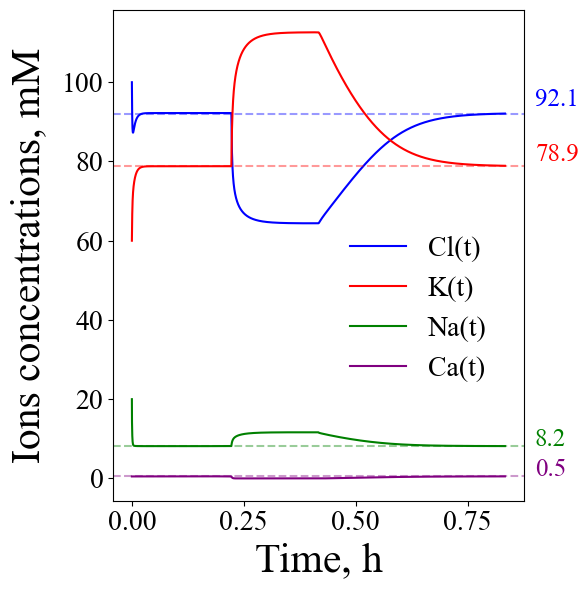

In [119]:
plot_solution_concentrations(tspan, solution, solution_stat=solution, V_arr=V_arr, V_arr_stat=V_arr,
                             x_text=0.9, legend_loc=[0.55, 0.22], save=True, save_name=stress_name, show_Ca=True)


0.0015785262101551767


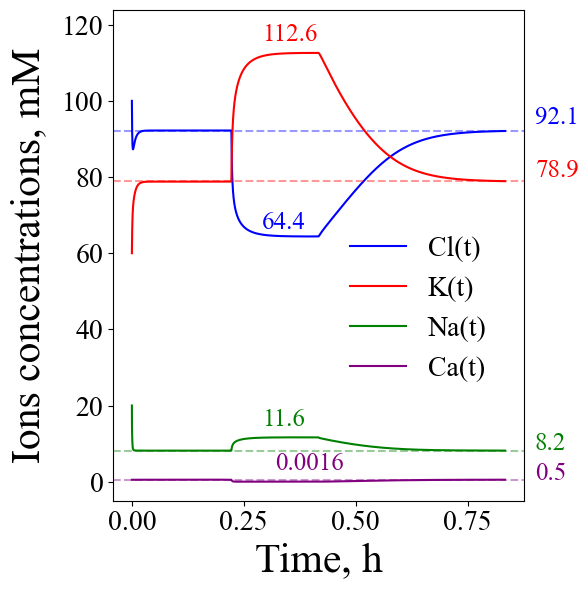

In [120]:
plot_solution_concentrations_stress(tspan, solution, solution_stat=solution, V_arr=V_arr, V_arr_stat=V_arr,
                             x_text=0.9, legend_loc=[0.55, 0.22], save=True, save_name=stress_name, show_Ca=True)


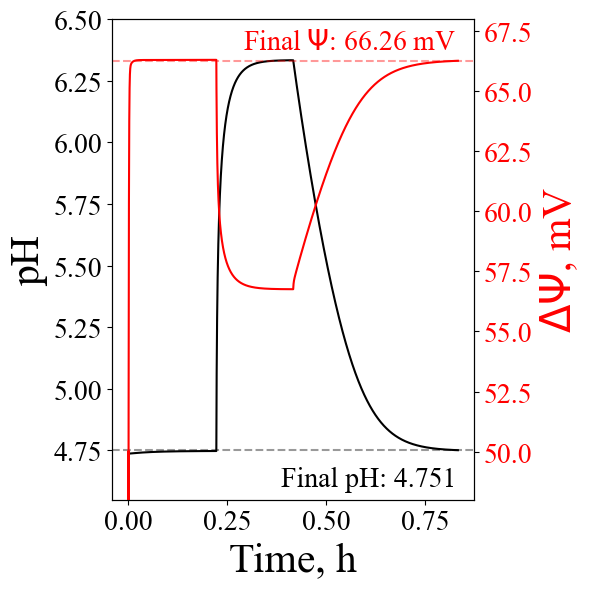

In [121]:
plot_solution_pH_psi(tspan, solution, solution, psi_arr, psi_arr[-1], 
                     psi_text=0.98, pH_text=0.07, set_pHlim=True, pHlim=[4.55, 6.5],
                     set_psi_lim=True, psi_lim=[48, 68],
                     save = True, save_name=stress_name)

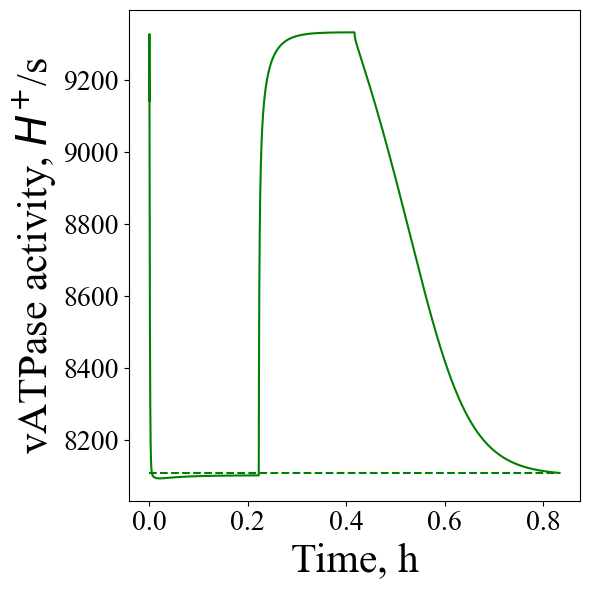

In [122]:


plot_vATPase_work(tspan, solution, solution, 'permeabilization100', psi_arr, psi_arr)

# Ca-signaling

## vATPase partial inhibition

In [123]:
tspan = np.arange(0, 8000, 1e-2)
solution = odeint(derivatives, X0, tspan, args=('Ca_v',))
tspan_stat = np.arange(0, 40000, 1e-2)
solution_stat = odeint(derivatives, X0, tspan_stat, args=('Ca_v',))

In [124]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

V_arr_stat = V_arr_def(solution_stat)
psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

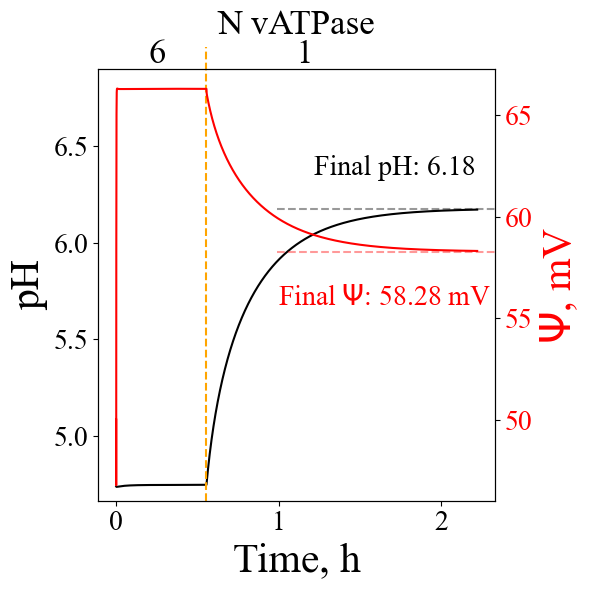

In [125]:

def plot_solution_pH_psi_Ca_v(t, solution, solution_stat, psi_arr, psi_stat,
                              save = False, save_folder = 'figs'):
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)

    t = t/3600

    # Plot R(t)
    ax1.plot(t, solution[:, 2], 'black', label='pH$(t)$')
    ax1.set_ylabel(r'pH', fontsize=30, color='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.axhline(solution_stat[:, 2][-1], 0.45, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax1.text(0.95, 0.8, 'Final pH: {:.2f}'.format(solution_stat[:, 2][-1]), transform=ax1.transAxes, ha='right', va='top', fontsize=20, color='black')
    ax1.set_ylim(ymax = 6.9)
    # Create a second y-axis for J_w_arr
    ax2 = ax1.twinx()

    # Plot J_w_arr
    psi_arr = (F/cap)*init_V*(solution[:, 1]/init_V/NA + solution[:, 3]/init_V/NA + solution[:, 4]/init_V/NA - solution[:, 5]/init_V/NA + 2*solution[:, 6]/init_V/NA - B)

    ax2.plot(t, psi_arr, 'r', label=r'$\Psi$(t)', alpha=1)  # Set transparency with alpha
    ax2.set_ylabel(r'$\Psi$, mV', fontsize=30, color='r')
    ax2.tick_params(axis='y', colors='black', labelcolor='red')
    ax2.axhline(psi_stat, 0.45, 1, color = 'r', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax2.text(0.99, 0.5, 'Final $\Psi$: {:.2f} mV'.format(psi_stat), transform=ax2.transAxes, ha='right', va='top', fontsize=20, color='r')

    ax2.set_ylim(ymin = 46)
    

    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=30)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black
    ax1.tick_params(axis='both', labelsize=20)
    ax2.tick_params(axis='both', labelsize=20)

    ax1.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax1.text(0.2, 6.93, s='6', fontsize=25, color='black')
    ax1.text(1, 6.93, s='  1', fontsize=25, color='black')
    # ax1.text(0.6, 7.5, s='N vATPase', fontsize=25, color='black')
    #add space between plot and title
    plt.title('N vATPase', fontsize=25, color='black', pad = 25)
    

    plt.tight_layout()

    if save:
        plt.savefig(f'{save_folder}/pH_psi_Ca_v.png', dpi = 300)
    plt.show()




plot_solution_pH_psi_Ca_v(tspan, solution, solution_stat, psi_arr, psi_arr_stat[-1], save=True)


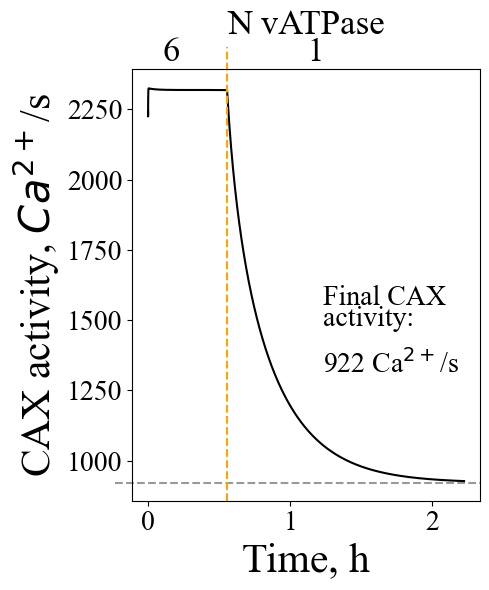

In [128]:


def plot_CAX_work_v(t_s, solution, solution_stat, psi_arr, psi_arr_stat, V_arr, V_arr_stat, save = 'False', save_folder = 'figs'):
    fig, ax = plt.subplots(figsize=(5, 6), dpi=100)
    t = t_s/3600
    pH_arr = solution[:, 2]
    Ca_F = solution[:, 6]/V_arr/NA 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    pH_L0   = (pH_arr+psi_in/(RTF*2.3))
    delta_pH    = pH_C0-pH_L0
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi_arr + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = 5*CAX_mu


    pH_arr_stat = solution_stat[:, 2]
    Ca_F_stat = solution_stat[:, 6]/V_arr_stat/NA
    Ca_F_C0_stat = Ca_C*exp(-2*psi_out/RTF)
    Ca_F_L0_stat = Ca_F_stat*exp(-2*psi_in/RTF)

    pH_C0_stat   = (pH_C+psi_out/(RTF*2.3))
    pH_L0_stat   = (pH_arr_stat+psi_in/(RTF*2.3))
    delta_pH_stat    = pH_C0_stat-pH_L0_stat
    CAX_mu_stat = (CAX_H - 2*CAX_Ca)*psi_arr_stat + RTF*(CAX_H*2.3*delta_pH_stat + CAX_Ca/2*np.log(Ca_F_L0_stat/Ca_F_C0_stat))
    J_CAX_stat = 5*CAX_mu_stat




    ax.plot(t, J_CAX, 'black', label='J_v$(t)$')
    ax.axhline(J_CAX_stat[-1], -0.05, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    plt.ylabel(r'CAX activity, $Ca^{2+}$/s', fontsize=30)
    plt.xlabel('Time, h', fontsize=30)
    ax.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax.text(0.1, 2420, s='6', fontsize=25, color='black')
    ax.text(1, 2420, s='  1', fontsize=25, color='black')
    plt.title('N vATPase', fontsize=25, color='black', pad = 25) 
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    


    ax.text(0.55, 0.5, 'Final CAX', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.55, 0.45, 'activity:', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')

    ax.text(0.55, 0.35, f'{J_CAX_stat[-1]:.0f} Ca$^{{2+}}$/s', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')  
    plt.tight_layout()
    if save:
        plt.savefig(f'{save_folder}/CAX_work_Ca_v.png', dpi=300)
    plt.show()


plot_CAX_work_v(tspan, solution, solution_stat, psi_arr, psi_arr_stat, V_arr, V_arr_stat, save = 'True')

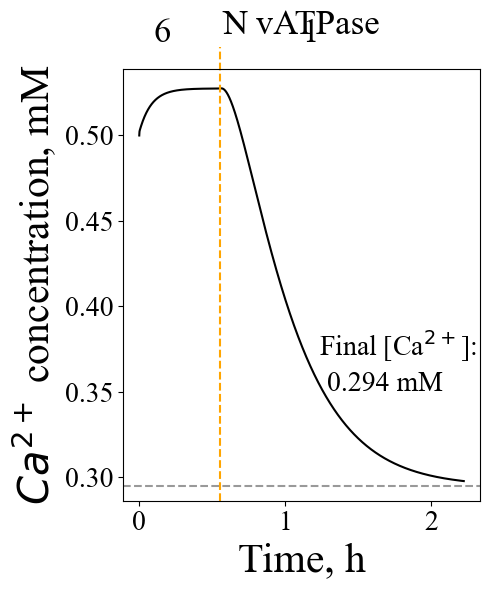

0.5258024228541626


In [129]:
def plot_solution_Ca_v(t_s, solution, solution_stat, V_arr, V_arr_stat, 
                       save= False, save_folder = 'figs'):
    fig, ax = plt.subplots(figsize=(5, 6), dpi=100)

    t = t_s/3600
    ca_conc = solution[:, 7] / V_arr / NA*1000
    ca_stat = solution_stat[:, 7][-1] / V_arr_stat[-1] / NA*1000
    # Plot the concentrations
    ax.plot(t, ca_conc, 'black')
    ax.axhline(ca_stat, 0, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)

    ax.set_ylabel(r'$Ca^{2+}$ concentration, mM', fontsize=30)
    ax.set_xlabel('Time, h', fontsize=30)
    ax.tick_params(axis='both', labelsize=20)
    # Add a vertical dashed line 
    ax.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax.text(0.1, 0.555, s='6', fontsize=25, color='black')
    ax.text(1, 0.555, s='  1', fontsize=25, color='black')
    plt.title('N vATPase', fontsize=25, color='black', pad = 25) 
    plt.tight_layout()
    ax.text(0.55, 0.4, 'Final [Ca$^{2+}$]:', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.57, 0.3, f'{ca_stat:.3f} mM', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')  
    ax.tick_params(axis='both', labelsize=20)

    plt.tight_layout()
    if save:
        plt.savefig(f'{save_folder}/Ca_Ca_v.png')
    plt.show()
    print(ca_conc[80000])


plot_solution_Ca_v(tspan, solution, solution_stat, V_arr, V_arr_stat, save=True)


## Pure de-acidification = proton efflux

In [130]:
tspan = np.arange(0, 8000, 1e-2)
solution = odeint(derivatives, X0, tspan, args=('Ca_al',))
tspan_stat = np.arange(0, 40000, 1e-2)
solution_stat = odeint(derivatives, X0, tspan_stat, args=('Ca_al',))

In [131]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

V_arr_stat = V_arr_def(solution_stat)
psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

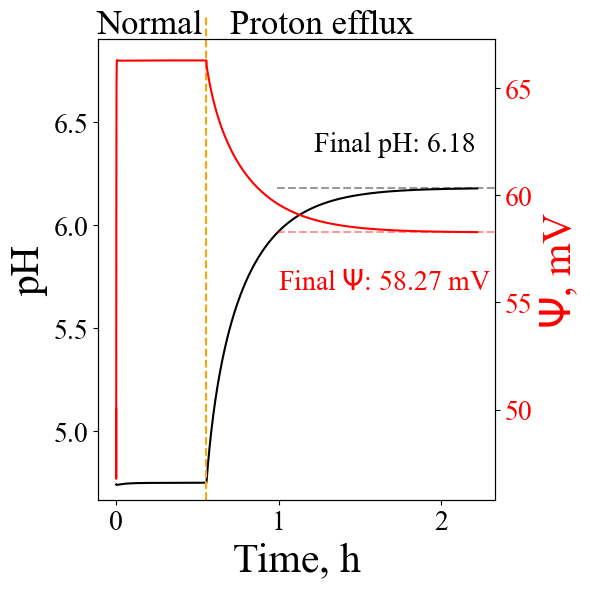

In [132]:
def plot_solution_pH_psi_Ca_a(t, solution, solution_stat, psi_arr, psi_stat, save = 'False', save_folder = 'figs'):
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)

    t = t/3600

    # Plot R(t)
    ax1.plot(t, solution[:, 2], 'black', label='pH$(t)$')
    ax1.set_ylabel(r'pH', fontsize=30, color='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.axhline(solution_stat[:, 2][-1], 0.45, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax1.text(0.95, 0.8, 'Final pH: {:.2f}'.format(solution_stat[:, 2][-1]), transform=ax1.transAxes, ha='right', va='top', fontsize=20, color='black')
    ax1.set_ylim(ymax = 6.9)
    # Create a second y-axis for J_w_arr
    ax2 = ax1.twinx()

    # Plot J_w_arr
    psi_arr = (F/cap)*init_V*(solution[:, 1]/init_V/NA + solution[:, 3]/init_V/NA + solution[:, 4]/init_V/NA - solution[:, 5]/init_V/NA + 2*solution[:, 6]/init_V/NA - B)

    ax2.plot(t, psi_arr, 'r', label=r'$\Psi$(t)', alpha=1)  # Set transparency with alpha
    ax2.set_ylabel(r'$\Psi$, mV', fontsize=30, color='r')
    ax2.tick_params(axis='y', colors='black', labelcolor='red')
    ax2.axhline(psi_stat, 0.45, 1, color = 'r', clip_on=False, linestyle='dashed', alpha = 0.4)
    ax2.text(0.99, 0.5, 'Final $\Psi$: {:.2f} mV'.format(psi_stat), transform=ax2.transAxes, ha='right', va='top', fontsize=20, color='r')

    # ax2.set_ylim(ymin = 46)
    

    # Set the x-axis label and tick color
    ax1.set_xlabel('Time, h', fontsize=30)
    ax1.tick_params(axis='x', colors='k')  # Set x-tick color to black


    ax1.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax1.text(0.7, 6.93, s='Proton efflux', fontsize=25, color='black')
    ax1.text(-0.12, 6.93, s='Normal', fontsize=25, color='black')
    # ax1.text(0.6, 7.5, s='N vATPase', fontsize=25, color='black')
    #add space between plot and title
    ax1.tick_params(axis='both', labelsize=20)
    ax2.tick_params(axis='both', labelsize=20)
    plt.tight_layout()
    if save:
        plt.savefig(f'{save_folder}/pH_psi_Ca_a.png', dpi=300)

    plt.show()
plot_solution_pH_psi_Ca_a(tspan, solution, solution_stat, psi_arr, psi_arr_stat[-1], save=True)


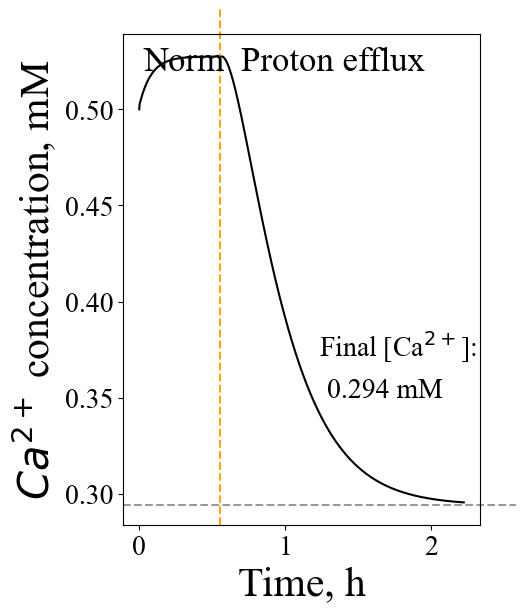

In [133]:
def plot_solution_Ca_a(t_s, solution, solution_stat, V_arr, V_arr_stat, save=False, save_folder = 'figs'):
    fig, ax = plt.subplots(figsize=(5, 6), dpi=100)

    t = t_s/3600
    ca_conc = solution[:, 7] / V_arr / NA*1000
    ca_stat = solution_stat[:, 7][-1] / V_arr_stat[-1] / NA*1000
    # Plot the concentrations
    ax.plot(t, ca_conc, 'black')
    ax.axhline(ca_stat, 0, 1.1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)

    ax.set_ylabel(r'$Ca^{2+}$ concentration, mM', fontsize=30)
    ax.set_xlabel('Time, h', fontsize=30)
    ax.tick_params(axis='both', labelsize=20)
    # Add a vertical dashed line 
    ax.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax.text(0.03, 0.52, s='Norm', fontsize=25, color='black')
    ax.text(0.7, 0.52, s='Proton efflux', fontsize=25, color='black')
    ax.text(0.55, 0.4, 'Final [Ca$^{2+}$]:', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.57, 0.3, f'{ca_stat:.3f} mM', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')  
    ax.tick_params(axis='both', labelsize=20)
    # plt.ylim(-0.025)
    plt.tight_layout()

    if save:
        plt.savefig(f'{save_folder}/Ca_Ca_a.png', dpi=300, bbox_inches='tight')

    
    plt.show()


plot_solution_Ca_a(tspan, solution, solution_stat, V_arr, V_arr_stat, save=True)


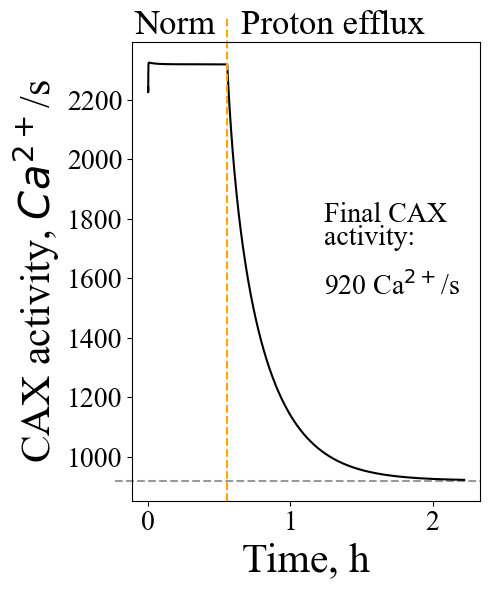

In [134]:


def plot_CAX_work_a(t_s, solution, solution_stat, psi_arr, psi_arr_stat, V_arr, V_arr_stat, save = 'True', save_folder = 'figs'):
    fig, ax = plt.subplots(figsize=(5, 6), dpi=100)
    t = t_s/3600
    pH_arr = solution[:, 2]
    Ca_F = solution[:, 6]/V_arr/NA 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    pH_L0   = (pH_arr+psi_in/(RTF*2.3))
    delta_pH    = pH_C0-pH_L0
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi_arr + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = 5*CAX_mu


    pH_arr_stat = solution_stat[:, 2]
    Ca_F_stat = solution_stat[:, 6]/V_arr_stat/NA
    Ca_F_C0_stat = Ca_C*exp(-2*psi_out/RTF)
    Ca_F_L0_stat = Ca_F_stat*exp(-2*psi_in/RTF)

    pH_C0_stat   = (pH_C+psi_out/(RTF*2.3))
    pH_L0_stat   = (pH_arr_stat+psi_in/(RTF*2.3))
    delta_pH_stat    = pH_C0_stat-pH_L0_stat
    CAX_mu_stat = (CAX_H - 2*CAX_Ca)*psi_arr_stat + RTF*(CAX_H*2.3*delta_pH_stat + CAX_Ca/2*np.log(Ca_F_L0_stat/Ca_F_C0_stat))
    J_CAX_stat = 5*CAX_mu_stat




    ax.plot(t, J_CAX, 'black', label='J_v$(t)$')
    ax.axhline(J_CAX_stat[-1], -0.05, 1, color = 'black', clip_on=False, linestyle='dashed', alpha = 0.4)
    plt.ylabel(r'CAX activity, $Ca^{2+}$/s', fontsize=30)
    plt.xlabel('Time, h', fontsize=30)
    ax.axvline(2000/3600, 0, 1.05, color = 'orange', clip_on=False, linestyle='dashed', alpha = 1)
    ax.text(0.65, 2420, s='Proton efflux', fontsize=25, color='black')
    ax.text(-0.1, 2420, s='Norm', fontsize=25, color='black')
    plt.tight_layout()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.ylim(top=2400)

    ax.text(0.55, 0.65, 'Final CAX', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.55, 0.6, 'activity:', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    ax.text(0.55, 0.5, f'{J_CAX_stat[-1]:.0f} Ca$^{{2+}}$/s', transform=ax.transAxes, ha='left', va='top', fontsize=20, color='black')
    plt.tight_layout()
    if save:
        plt.savefig(f'{save_folder}/CAX_work_Ca_a.png', dpi=300)   
    plt.show()





plot_CAX_work_a(tspan, solution, solution_stat, psi_arr, psi_arr_stat, V_arr, V_arr_stat, save=True)

# Accumulation of weak base, “proton sponge”-like cationic amphiphilic drug (CAD)

In [135]:
init_Sp = 0.1
init_HSp = 0
Sp_C = 0.001
ohsp = 0.73

In [311]:
# @jit
def derivatives_sponge(X, t):
    '''
    compute derivatives of X wrt time
    '''
    Aeff, NH, pH, NK, NNa, NCl, NCa_T, NCa_F, R, NSp = X


    k_times = 4

    N_VATP = 6
    N_CAX = 16
    p = 3.88e-12

    P_Ca = 1.49e-7         #[ion*cm/s]
    P_Cl = 1.2e-5       #[ion*cm/s]
    P_H = 6e-05      #[ion*cm/s]
    P_K = 7.1e-7      #[ion*cm/s]
    P_Na = 9.6e-7      #[ion*cm/s]
    Pw = 0.054e+10


    
     
    
    V = (4/3*3.1416*abs(R)**3*1e-12)/1000
    S = 4*3.1416*abs(R)**2*1e-8


    #Luminal Concentrations
    H = NH/V/NA
    K = NK/V/NA
    Na = NNa/V/NA
    Cl = NCl/V/NA
    Ca_F = NCa_F/V/NA
    Ca_T = NCa_T/V/NA
    r = Ca_F/Ca_T
    Sp = NSp/V/NA
    HSp = init_Sp-Sp

    
    #membrane potential
#     psi = (F/cap)*init_V*(H + K + Na - Cl + 2*Ca_T - B)
    psi = (F/cap)*(V*(H + K + Na - Cl + 2*Ca_T) - B*init_V)


#      Modified Cytoplasmic Surface Concentrations
    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    K_C0    = K_C*exp(-psi_out/RTF)
    Na_C0   = Na_C*exp(-psi_out/RTF) 
    Cl_C0   = Cl_C*exp(psi_out/RTF) 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    
#     Modified Luminal Surface Concentrations
    pH_L0   = (pH+psi_in/(RTF*2.3))
    K_L0    = K*exp(-psi_in/RTF)
    Na_L0   = Na*exp(-psi_in/RTF) 
    Cl_L0   = Cl*exp(psi_in/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    delta_pH    = pH_C0-pH_L0;  

#     Treatment of singular terms for passive ion flux
    if (abs(psi) > 300):
        psi = np.sign(psi)*300
    if (abs(psi) > 0.01):
        gg      =  psi / (1 - exp (- psi / RTF)) / RTF
        gg_Ca   = 2*psi/(1-exp(-2*psi/RTF))/RTF

    else: 
        gg      =  1 / 1 - (psi / RTF)/2 + (psi / RTF)**2/6 - (psi / RTF)**3 / 24 + (psi / RTF) ** 4 / 120
        gg_Ca   = 1/(1 - (psi/RTF) + (2/3)*(psi/RTF)**2 - (1/3)*(psi/RTF)**3 +(2/15)*(psi/RTF)**4)
        

    # vAPTase
    J_VATPASE  = N_VATP * J_v(pH, psi)


        # ClC-7 Antiporter {H out, Cl in}
    CLC_mu      = (CLC_H + CLC_Cl)*psi + RTF*(CLC_H*2.3*delta_pH + CLC_Cl*np.log(Cl_C0/Cl_L0))
    
    #     Switching function   
    x = 0.5 + 0.5*np.tanh((CLC_mu + 250)/75); 
    # Activity
    A = 0.3*x + 1.5E-5*(1-x)*CLC_mu**2;
    
    if (A < Aeff):
        tau = tau_deact
    else:
        tau = tau_act
        
    J_CLC    = N_CLC*Aeff*CLC_mu 
    
    
#      CAX Antiporter {H out, Ca in} [mV, ion/s]
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = N_CAX*CAX_mu
    
    
    
    
#      Passive flux [ion/s]
    J_H = P_H*S*(10**(-pH_C0)*exp(-psi/RTF)-10**(-pH_L0))*gg*NA/1000
    J_K = P_K*S*(K_C0*exp(-psi/RTF)-K_L0)*gg*NA/1000
    J_Na = P_Na*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000

    J_Cl_unc = P_Cl*S*(Cl_C0-Cl_L0*exp(-psi/RTF))*gg*NA/1000
    J_Ca = P_Ca*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000
    


    
    #water flux
    J_w = Pw*S*(oh*10**(-pH) + ok*K + ona*Na + ocl*Cl + ohsp*HSp + Q/V - Oc)
    
#     TRPML1 channel
    y = 0.5 - 0.5*np.tanh(psi + 40)
    P_trpml1 = p*(y*abs(psi) + (1-y)*(abs (psi + 40)**3)/(pH_L0**q))
    J_Ca_trpml1 = P_trpml1*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000

    J_vNa = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = naflux_psi)
    J_vK = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = kflux_psi)


    xh = 6.7e3*exp(-0.9*pH) - 15
    k = 11.3*pH**2 - 116.5*pH + 325.3
    P_TPC = 1/(1+exp((xh-psi)/k))
    J_TPC = N_TPC*P_TPC*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000
    #Sponge


    k_fus = 1e3
    k_fis = 1e-2

    w_fus = k_fus*np.power(10, -pH)*Sp

    w_fis = k_fis*HSp
    w = (w_fus-w_fis)*NA*V
    Sp_add_flux = 10e3

    dxdt = [(1/tau)*(A - Aeff)/k_times,
        (J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - w)/k_times, 
           (-(J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - w)/V/NA)/beta_pH/k_times,
           (J_K + N_NKA*J_vK)/k_times,
           (J_Na + N_NKA*J_vNa + J_TPC)/k_times,
           (J_Cl_unc + (CLC_Cl*J_CLC))/k_times,
           (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)/k_times,
           (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)*r/k_times, 
           J_w/(1000*55)/(4*np.pi*(R/1e5)**2)*1e5*0,
           -w+Sp_add_flux]
    

    return dxdt

In [312]:
init_NH = init_H*init_V*NA;      #[ions]
init_NK = init_K*init_V*NA;       
init_NNa = init_Na*init_V*NA;    
init_NCl = init_Cl*init_V*NA;     
init_NCa_T = init_Ca_T*init_V*NA; 
init_NCa_F = init_Ca_F*init_V*NA; 
init_NSp = init_Sp*init_V*NA; 

X0_sp = [init_Aeff, init_NH, init_pH, init_NK, init_NNa, init_NCl, init_NCa_T, init_NCa_F, init_R, init_NSp]

In [313]:
tspan = np.arange(0, 1200, 1e-2)
solution = odeint(derivatives_sponge, X0_sp, tspan)

tspan_stat = np.arange(0, 40000, 1e-2)
solution_stat = odeint(derivatives_sponge, X0_sp, tspan_stat)

In [314]:
def J_w_arr_sponge_def(solution, V_arr):
    init_Sp_arr = np.full(len(solution[:, 9]), init_Sp)
    J_w_arr = Pw*4*3.1416*abs(solution[:, 8])**2*1e-8*(oh*10**(-solution[:, 2]) + ok*solution[:, 3]/V_arr/NA + ona*solution[:, 4]/V_arr/NA + ocl*solution[:, 5]/V_arr/NA + ohsp*(init_Sp_arr - solution[:, 9] / V_arr / NA)  + Q/V_arr - Oc)
    return J_w_arr*1000*NA

In [315]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_sponge_def(solution, V_arr)

V_arr_stat = V_arr_def(solution_stat)
psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
J_w_arr_stat = J_w_arr_sponge_def(solution_stat, V_arr_stat)

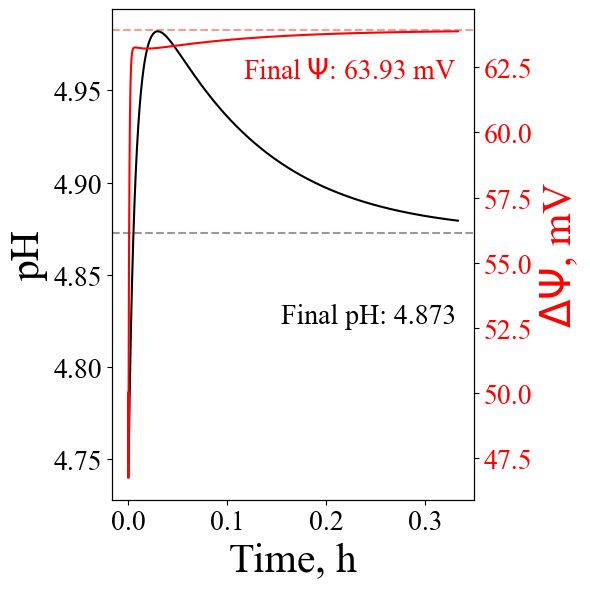

In [316]:
plot_solution_pH_psi(tspan, solution, solution_stat, psi_arr, psi_arr_stat[-1], psi_text=0.9, pH_text=0.4,
                     save = True, save_name='sponge')

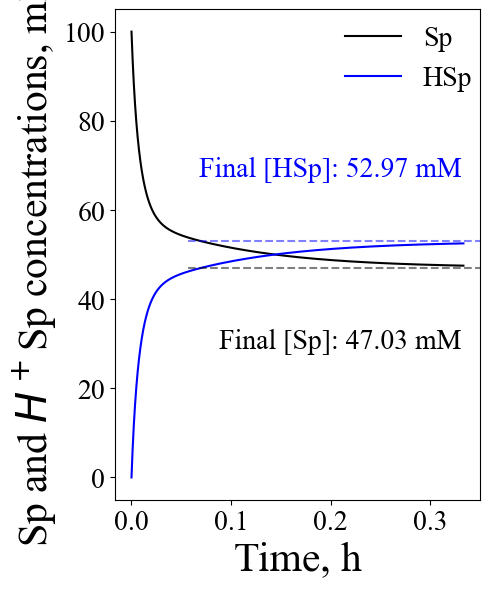

In [317]:
def plot_solution_sp(t, solution, solution_stat, V_arr, V_arr_stat, save = False, save_folder = 'Figs'):
    t = t/3600
    fig, ax = plt.subplots(figsize=(5, 6), dpi=100)
    init_Sp_arr = np.full(len(solution[:, 9]), init_Sp)
    ax.plot(t, solution[:, 9] / V_arr / NA*1000, 'black', label='Sp')
    ax.plot(t, (init_Sp_arr - solution[:, 9] / V_arr / NA)*1000, 'b', label='HSp')

    Sp_stat = solution_stat[:, 9][-1] / V_arr_stat[-1] / NA
    HSp_stat = init_Sp_arr[-1] - Sp_stat
    ax.axhline(y=Sp_stat*1000, xmin=0.2, xmax=1, color='black', linestyle='--', alpha=0.5)
    ax.axhline(y=HSp_stat*1000, xmin=0.2, xmax=1 ,color='b', linestyle='--', alpha=0.5)


    ax.text(0.95, 0.7, 'Final [HSp]: {:.2f} mM'.format(HSp_stat*1000), transform=ax.transAxes, ha='right', va='top', fontsize=20, color='b')
    ax.text(0.95, 0.35, 'Final [Sp]: {:.2f} mM'.format(Sp_stat*1000), transform=ax.transAxes, ha='right', va='top', fontsize=20, color='black')

    ax.set_xlabel(f'Time, h', fontsize=30)
    ax.set_ylabel(r'Sp and $H^+$Sp concentrations, mM', fontsize=30)
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(loc=(0.6, 0.81), fontsize=20, frameon=False)
    ax.tick_params(axis='both', labelsize=20)
    plt.tight_layout()
    if save:
        plt.savefig(f'{save_folder}/Sp.png', dpi=300)
    plt.show()

plot_solution_sp(tspan, solution, solution_stat, V_arr, V_arr_stat, save = True)

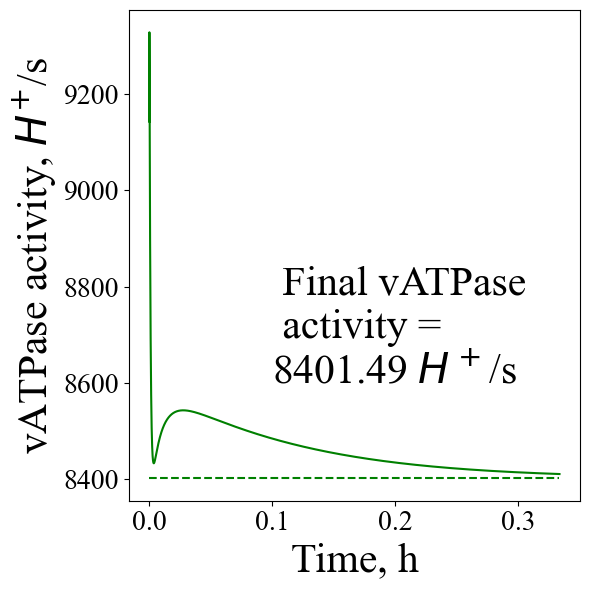

In [318]:
def plot_vATPase_work(t, solution, solution_stat, save_name, psi_arr, psi_arr_stat):
    t = t/3600
    plt.figure(figsize=(6,6), dpi=100)
    v_arr = np.vectorize(J_v)(solution[:, 2], psi_arr)
    v_arr_stat = J_v(solution_stat[:, 2][-1], psi_arr_stat[-1])
    plt.plot(t, v_arr, 'g', label='J_v$(t)$')
    plt.ylabel(r'vATPase activity, $H^{+}$/s', fontsize=30)
    plt.xlabel('Time, h', fontsize=30)
    plt.xticks(fontsize=20)
    plt.hlines(v_arr_stat, t[0], t[-1], linestyle='--', color='g', label='J_v$(t_{stat})$')
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.text(0.1, 8600, ' Final vATPase \n activity = \n'  + str(round(v_arr_stat, 2)) + r' $H^+$/s', fontsize=30)
    plt.savefig('figs/' + save_name + '_JV.png', dpi=300)
    plt.show()

plot_vATPase_work(tspan, solution, solution_stat, 'Sp', psi_arr, psi_arr_stat)

# Maturatuion

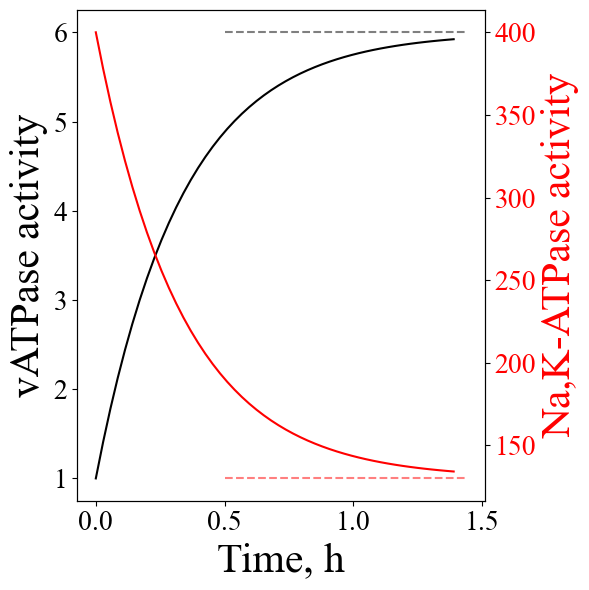

In [319]:
def N_VATP_plot(t):
    N_VATP_end = 6
    N_VATP_start = 1

    t_end = 6000
    if t<=t_end:
        N_VATP = (N_VATP_end - N_VATP_start)*(1-np.exp(-t*5/t_end)) + N_VATP_start
    else:
        N_VATP = N_VATP_end

    return N_VATP

def N_NKA_plot(t):
    N_NKA_end = 13000
    N_NKA_start = 40000
    t_end = 6000
    if t<=t_end:
        N_NKA = (N_NKA_end - N_NKA_start)*(1-np.exp(-t*5/t_end)) + N_NKA_start
    else:
        N_NKA = N_NKA_end

    return N_NKA

def N_TPC_plot(t):
    N_TPC_end = 10
    N_TPC_start = 100
    t_end = 6000
    if t<=t_end:
        N_TPC = (N_TPC_end - N_TPC_start)*(1-np.exp(-t*5/t_end)) + N_TPC_start
    else:
        N_TPC = N_TPC_end

    return N_TPC


t_ar = np.linspace(0, 5000)

fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)
ax1.plot(t_ar/3600, np.vectorize(N_VATP_plot)(t_ar), 'black')
ax1.hlines(6, 0.5, 5000/3600+0.05, color='black', clip_on=False, linestyle='dashed', alpha=0.5)

ax2 = ax1.twinx()

ax2.plot(t_ar/3600, np.vectorize(N_NKA_plot)(t_ar)/100, 'red')
ax2.tick_params(axis='y', colors='black', labelcolor='red')
ax2.hlines(130, 0.5, 5000/3600+0.05, color='red',clip_on=False, linestyle='dashed', alpha=0.5)
ax1.set_xlabel('Time, h', fontsize=30)
ax1.set_ylabel('vATPase activity', fontsize=30, color='black')
ax2.set_ylabel('Na,K-ATPase activity', fontsize=30, color='red')

from matplotlib.ticker import ScalarFormatter

sf = ScalarFormatter()
sf.set_powerlimits((-6, 4))
ax2.yaxis.set_major_formatter(sf)

plt.tight_layout()
plt.savefig('figs/maturation_NKA_vATP.png', dpi = 300)




In [320]:
init_R_endosome = 0.35
init_pH_endosome = 5.8
init_H_endosome = np.power(10, -init_pH_endosome)
init_K_endosome = 0.04
init_Na_endosome = 0.05
init_Cl_endosome = 0.06
init_Ca_T_endosome = 0.006
init_Ca_F_endosome = 0.0006
init_V_endosome = (4/3*3.1416*init_R_endosome**3*1e-12)/1000
B = init_K_endosome+init_Na_endosome+init_H_endosome-init_Cl_endosome  + init_Ca_T_endosome*2 - cap/F/init_V_endosome*(psi_in - psi_out)

In [321]:
def derivatives_mat(X, t):
    '''
    compute derivatives of X wrt time
    '''
    Aeff, NH, pH, NK, NNa, NCl, NCa_T, NCa_F, R = X

    N_VATP_end = 6
    N_VATP_start = 1
    N_TPC_end = 10
    N_TPC_start = 100
    k_times = 4

    N_NKA_end = 13000
    N_NKA_start = 50000
    t_end = 4000


    if t<=t_end:
        N_VATP = (N_VATP_end - N_VATP_start)*(1-np.exp(-t*5/t_end)) + N_VATP_start
        N_NKA = (N_NKA_end - N_NKA_start)*(1-np.exp(-t*5/t_end)) + N_NKA_start
        N_TPC = (N_TPC_end - N_TPC_start)*(1 - np.exp(-t*5/t_end)) + N_TPC_start
    else:
        N_NKA = N_NKA_end
        N_VATP = N_VATP_end
        N_TPC = N_TPC_start


    N_CAX = 16
    p = 3.88e-12

    P_Ca = 0        #[ion*cm/s]
    P_Cl = 1.2e-5       #[ion*cm/s]
    P_H = 6e-05      #[ion*cm/s]
    P_K = 7.1e-7      #[ion*cm/s]
    P_Na = 9.6e-7      #[ion*cm/s]
    Pw = 0.054e-2


    pure_basefication = 0


     
    
    V = (4/3*3.1416*abs(R)**3*1e-12)/1000
    S = 4*3.1416*abs(R)**2*1e-8


    #Luminal Concentrations
    H = NH/V/NA
    K = NK/V/NA
    Na = NNa/V/NA
    Cl = NCl/V/NA
    Ca_F = NCa_F/V/NA
    Ca_T = NCa_T/V/NA
    r = Ca_F/Ca_T

    
    
    #membrane potential
#     psi = (F/cap)*init_V*(H + K + Na - Cl + 2*Ca_T - B)
    psi = (F/cap)*(V*(H + K + Na - Cl + 2*Ca_T) - B*init_V)


#      Modified Cytoplasmic Surface Concentrations
    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    K_C0    = K_C*exp(-psi_out/RTF)
    Na_C0   = Na_C*exp(-psi_out/RTF) 
    Cl_C0   = Cl_C*exp(psi_out/RTF) 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    
#     Modified Luminal Surface Concentrations
    pH_L0   = (pH+psi_in/(RTF*2.3))
    K_L0    = K*exp(-psi_in/RTF)
    Na_L0   = Na*exp(-psi_in/RTF) 
    Cl_L0   = Cl*exp(psi_in/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    delta_pH    = pH_C0-pH_L0;  

#     Treatment of singular terms for passive ion flux
    if (abs(psi) > 300):
        psi = np.sign(psi)*300
    if (abs(psi) > 0.01):
        gg      =  psi / (1 - exp (- psi / RTF)) / RTF
        gg_Ca   = 2*psi/(1-exp(-2*psi/RTF))/RTF

    else: 
        gg      =  1 / 1 - (psi / RTF)/2 + (psi / RTF)**2/6 - (psi / RTF)**3 / 24 + (psi / RTF) ** 4 / 120
        gg_Ca   = 1/(1 - (psi/RTF) + (2/3)*(psi/RTF)**2 - (1/3)*(psi/RTF)**3 +(2/15)*(psi/RTF)**4)
        

    # vAPTase
    J_VATPASE  = N_VATP * J_v(pH, psi)


        # ClC-7 Antiporter {H out, Cl in}
    CLC_mu      = (CLC_H + CLC_Cl)*psi + RTF*(CLC_H*2.3*delta_pH + CLC_Cl*np.log(Cl_C0/Cl_L0))
    
    #     Switching function   
    x = 0.5 + 0.5*np.tanh((CLC_mu + 250)/75); 
    # Activity
    A = 0.3*x + 1.5E-5*(1-x)*CLC_mu**2;
    
    if (A < Aeff):
        tau = tau_deact
    else:
        tau = tau_act
        
    J_CLC    = N_CLC*Aeff*CLC_mu 
    
    
#      CAX Antiporter {H out, Ca in} [mV, ion/s]
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = N_CAX*CAX_mu
    
    xh = 6.7e3*exp(-0.9*pH) - 15
    k = 11.3*pH**2 - 116.5*pH + 325.3
    P_TPC = 1/(1+exp((xh-psi)/k))
    J_TPC = N_TPC*P_TPC*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000
    
    
#      Passive flux [ion/s]
    J_H = P_H*S*(10**(-pH_C0)*exp(-psi/RTF)-10**(-pH_L0))*gg*NA/1000
    J_K = P_K*S*(K_C0*exp(-psi/RTF)-K_L0)*gg*NA/1000
    J_Na = P_Na*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000

    # J_K = P_K*S*((K_C0+Na_C0)*exp(-psi/RTF)-(K_L0+Na_L0))*gg*NA/1000
    # J_Na = P_Na*S*((Na_C0+K_C0)*exp(-psi/RTF)-(K_L0+Na_L0))*gg*NA/1000
    J_Cl_unc = P_Cl*S*(Cl_C0-Cl_L0*exp(-psi/RTF))*gg*NA/1000
    J_Ca = P_Ca*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000
    


    
    #water flux
    J_w = Pw*S*(oh*10**(-pH) + ok*K + ona*Na + ocl*Cl + Q/V - Oc)
    
#     TRPML1 channel
    y = 0.5 - 0.5*np.tanh(psi + 40)
    P_trpml1 = p*(y*abs(psi) + (1-y)*(abs (psi + 40)**3)/(pH_L0**q))
    J_Ca_trpml1 = P_trpml1*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000

    J_vNa = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = naflux_psi)
    J_vK = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = kflux_psi)


    

    
    dxdt = [(1/tau)*(A - Aeff)/k_times,
        (J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication)/k_times, 
           (-(J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication)/V/NA)/beta_pH/k_times,
           (J_K + N_NKA*J_vK)/k_times,
           (J_Na + N_NKA*J_vNa + J_TPC)/k_times,
           (J_Cl_unc + (CLC_Cl*J_CLC))/k_times,
           (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)/k_times,
           (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)*r/k_times, 
           J_w/(1000*55)/(4*np.pi*(R/1e5)**2)*1e5*0]

    return dxdt

In [322]:
init_NH = init_H_endosome*init_V_endosome*NA;      #[ions]
init_NK = init_K_endosome*init_V_endosome*NA;       
init_NNa = init_Na_endosome*init_V_endosome*NA;    
init_NCl = init_Cl_endosome*init_V_endosome*NA;     
init_NCa_T = init_Ca_T_endosome*init_V_endosome*NA; 
init_NCa_F = init_Ca_F_endosome*init_V_endosome*NA; 

X0_mat = [init_Aeff, init_NH, init_pH_endosome, init_NK, init_NNa, init_NCl, init_NCa_T, init_NCa_F, init_R_endosome]

In [323]:
tspan = np.arange(0, 5000, 1e-2)
solution = odeint(derivatives_mat, X0_mat, tspan)

tspan_stat = np.arange(0, 40000, 1e-2)
solution_stat = odeint(derivatives_mat, X0_mat, tspan_stat)

In [324]:
V_arr = V_arr_def(solution)
psi_arr = Psi_arr_def(solution, V_arr)
J_w_arr = J_w_arr_def(solution, V_arr)

V_arr_stat = V_arr_def(solution_stat)
psi_arr_stat = Psi_arr_def(solution_stat, V_arr_stat)
J_w_arr_stat = J_w_arr_def(solution_stat, V_arr_stat)

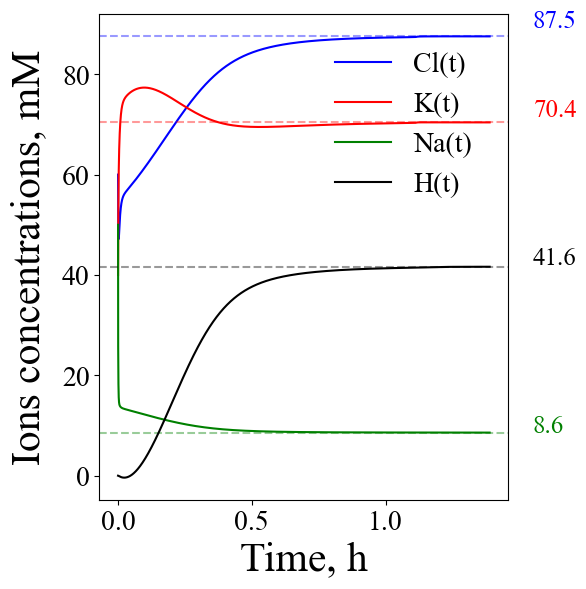

In [325]:
plot_solution_concentrations(tspan, solution, solution_stat=solution_stat, V_arr=V_arr, V_arr_stat=V_arr_stat,
                             x_text=1.55, save=True, save_name='maturation', show_H=True)


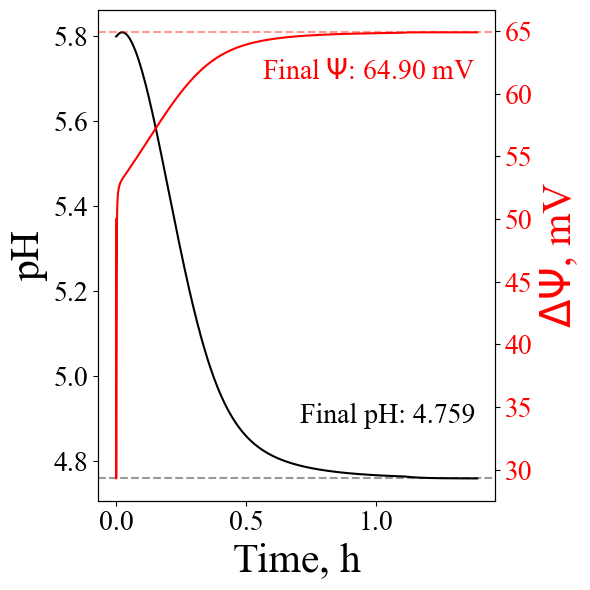

In [302]:
plot_solution_pH_psi(tspan, solution, solution_stat, psi_arr, psi_arr_stat[-1], psi_text=0.9, pH_text=0.2,
                     set_pHlim=False, pHlim=[4.6, 5.25], save=True, save_name='Maturation')